# Sephora Sentiment Prediction Classifer

## Introduction
#### The Sentiment Prediction includes 2 main objectives
1. sentiment prediction
- to explore and train a classfier to predict the sentiment of reviews using NB
- to understand key features contributing to the sentiments 

2. Aspect-Based Sentiment Analysis (ABSA)
- to deal with mixed sentiments
- potentially to mine sentiment keywords using EDA

#### The content of this notebook includes the followings
- [About classfier pipeline](#about-classfier-pipeline)
- [Model Training Baseline](#model-training-baseline)
- [Advanced EDA](#advanced-eda)
- [Model Comparision](#model-comparision)
- [Model Improvement](#model-improvement)
- [Model Comparision](#model-comparision)
- [Validation](#validation)
- [Combination of base models](#combination-of-base-models)
- [Advanced Analysis](#advanced-analysis)

## About classfier pipeline


the defination are stored seperately in sentiment_nb.py file, and import into the jupyter notebook for cleaer flow, some functions are listed below:

class classifer
- preprocesser: lowercase, stopword, lemmatizer, remove_plural, customized_stopword
- vectorizer: count, tfidf, word2vec
- naive bayes classfier: preprocessors -> vectorizer -> train -> evaluate
- further fine tuning model combination

class Visualization
- draw confusion_matrix for different labels
- draw samples of wrongly classfied text to understand why its wrongly labeled
- show top features which contributes to the prediction 

class Validator
- take in munual text input
- predict the label for munual validation

## Model Training Baseline

In [1]:
import pandas as pd
from wordcloud import WordCloud, STOPWORDS
import seaborn as sns
import matplotlib.pyplot as plt
from naive_bayes_utils import NaiveBayesClassifier, Validator, NaiveBayesVisualization

In [207]:
# set display options for max column width
pd.set_option('display.max_colwidth', 30)

latest_review = pd.read_csv('data/latest_review.csv')
latest_review.head(3)

/var/folders/8z/fr1y76rn6js5w526_mc9y1hh0000gn/T/ipykernel_59960/3818068816.py:4: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  latest_review = pd.read_csv('../data/latest_review.csv')


author_id  rating  is_recommended  helpfulness  total_feedback_count  \
0   1796832802       3             0.0     0.714286                     7   
1  10255886039       2             0.0     0.500000                     2   
2   5049431408       5             1.0     1.000000                     4   

   total_neg_feedback_count  total_pos_feedback_count submission_time  \
0                         2                         5      2022-12-31   
1                         1                         1      2022-12-31   
2                         0                         4      2022-12-31   

                     review_text                   review_title  ...  \
0  I decided to try this as I...  Decent, but cheaper produc...  ...   
1  Might as well be putting o...            Where’s the smell??  ...   
2  Love this lip mask nothing...                      Must buy!  ...   

  hair_color product_id                   product_name brand_name price_usd  \
0        red    P420652  Lip Sleeping Mask Intense ...    LANEIGE      24.0   
1        NaN    P420652  Lip Sleeping Mask Intense ...    LANEIGE      24.0   
2     blonde    P420652  Lip Sleeping Mask Intense ...    LANEIGE      24.0   

  primary_category      secondary_category  tertiary_category true_sentiment  \
0         Skincare  Lip Balms & Treatments                NaN        neutral   
1         Skincare  Lip Balms & Treatments                NaN       negative   
2         Skincare  Lip Balms & Treatments                NaN       positive   

  length  
0    172  
1    160  
2     92  

[3 rows x 23 columns]

In [3]:
# understand what are the columns in the dataset
latest_review.columns

Index(['author_id', 'rating', 'is_recommended', 'helpfulness',
       'total_feedback_count', 'total_neg_feedback_count',
       'total_pos_feedback_count', 'submission_time', 'review_text',
       'review_title', 'skin_tone', 'eye_color', 'skin_type', 'hair_color',
       'product_id', 'product_name', 'brand_name', 'price_usd',
       'primary_category', 'secondary_category', 'tertiary_category',
       'true_sentiment', 'length'],
      dtype='object')

In [4]:
# only keep relevent cols to reduce processing time
columns_to_keep = ['rating', 'is_recommended', 'helpfulness','submission_time', 
                   'review_text','review_title', 'length',
                   'product_name', 'brand_name', 'price_usd',
                   'primary_category', 'secondary_category', 'tertiary_category',
                   'true_sentiment', ]
latest_review = latest_review[columns_to_keep]

In [5]:
# set color scheme to "set2“
sns.color_palette("pastel")

# Get the color palette as a list
color_palette = sns.color_palette()

After simple EDA (refer to main file), a classfier pipeline using Naive Bay model is constructed. The baseline model is using clean text without further engineered features. 

The parameters used for the baseline model as below:
- target variables: true sentiments (<=2: negative, =3: neutral, >=4: positive)
- input data: all reviews
- features: only 'review_text'
- preprocessor: lowercase
- vectorizer: count


In [6]:
# train baseline model with latest_review for the baseline model
preprocessors = ['lowercase']
baseline_nb_classifier = NaiveBayesClassifier(data=latest_review, text_col='review_text', preprocessors=preprocessors)
train_metrics, test_metrics = baseline_nb_classifier.train(vectorizer_type='count', use_additional_features=False)

In [7]:
# get the basic evaluation/accuracy metrics
print(f"Train Accuracy: {train_metrics['accuracy']:.5f}")
print(f"Test Accuracy: {test_metrics['accuracy']:.5f}")

Train Accuracy: 0.88093
Test Accuracy: 0.87062


In [8]:
# set column labels
labels = sorted(baseline_nb_classifier.data['true_sentiment'].unique())
index_labels = [f"True {label}" for label in labels]
column_labels = [f"Predicted {label}" for label in labels]

# get train evaluation for train set
print("\nTrain:")
baseline_nb_classifier.display_results(train_metrics)

confusion_df = pd.DataFrame(train_metrics['confusion_mat'], index=index_labels, columns=column_labels)
print("\nConfusion Matrix:")
confusion_df


Train:
accuracy: 0.88093
precision: 0.88494
recall: 0.88093
f1: 0.88279
f2: 0.88173

Confusion Matrix:


Predicted negative  Predicted neutral  Predicted positive
True negative                7539               1136                1812
True neutral                 1489               4203                3106
True positive                2234               3956               89861

In [9]:
# get train evaluation for test set
print("\nTest:")
baseline_nb_classifier.display_results(test_metrics)

confusion_df = pd.DataFrame(test_metrics['confusion_mat'], index=index_labels, columns=column_labels)
print("\nConfusion Matrix:")
confusion_df


Test:
accuracy: 0.87062
precision: 0.87106
recall: 0.87062
f1: 0.87080
f2: 0.87071

Confusion Matrix:


Predicted negative  Predicted neutral  Predicted positive
True negative                4496                907                1408
True neutral                 1196               2181                2413
True positive                1442               2582               60266

In [10]:
results_list = []

new_entry = {
    'Name': 'Baseline Model',
    'Train Accuracy': train_metrics['accuracy'],
    'Train Precision': train_metrics['precision'],
    'Train Recall': train_metrics['recall'],
    'Train F1': train_metrics['f1'],
    'Train F2': train_metrics['f2'],
    'Train Confusion Matrix': train_metrics['confusion_mat'].tolist(), 
    'Test Accuracy': test_metrics['accuracy'],
    'Test Precision': test_metrics['precision'],
    'Test Recall': test_metrics['recall'],
    'Test F1': test_metrics['f1'],
    'Test F2': test_metrics['f2'],
    'Test Confusion Matrix': test_metrics['confusion_mat'].tolist(), 
    'Preprocesser': preprocessors, 
    'Vectorizer': 'count',
    'Classifier': 'Naive Bayes',
    'Feature': 'review_text',
    'Target': 'positive, negative, neutral',
    'remarks': 'baseline model'
}

results_list.append(new_entry)
# results_list


In [11]:
# sample incorrect prediction 
from naive_bayes_utils import NaiveBayesVisualization
visualizer = NaiveBayesVisualization(baseline_nb_classifier)
visualizer.display_incorrect_samples(2)

Review: Love this lip mask nothing else will do Aquaphor and Vaseline just aren’t as moisturizing as this mask is I recommend it to everyone I know￼
Review Procrssed: love this lip mask nothing else will do aquaphor and vaseline just aren’t as moisturizing as this mask is i recommend it to everyone i know￼
Actual Sentiment: positive
Predicted Sentiment: negative

Review: I had chapped lips suddenly (normally not a problem for me) and after several days of lip balm/chapstick, they only started healing once I started using this. I had a sample from a reward or birthday gift. I will definitely keep it on hand for the future.
Review Procrssed: i had chapped lips suddenly normally not a problem for me and after several days of lip balmchapstick they only started healing once i started using this i had a sample from a reward or birthday gift i will definitely keep it on hand for the future
Actual Sentiment: positive
Predicted Sentiment: negative

Review: This product has been blowing up so I

it is observed from both confusion matrix and sample data:
- the classfier does not prefrom well with neutral labeled data. With human observation, many of 'netural' data are not netural but contains sentiments, such data might create a nosie to the whole dataset. 
- misclassification among positive and negtive to be imporved  

### evaluation metrics

Primary metrics: F2 & RECALL (Weighted Average), secondary metrcis: confusion matrix
- Recall = TP / (TP + FN)
- F2-Score = (1 + 2^2) x (Precision x Recall) / (2^2 x Precision + Recall)

Confusion Matrix: Shows where the model is making mistakes.
- TP = True Positives
- FP = False Positives
- TN = True Negatives
- FN = False Negatives

we are dealing with class imbalance, the weighted average might be more informative.
   - Weighted-Precision = SUM(w_i x Precision_i) from i=1 to N

using the weighted average would be more representative of the model's performance on the dataset.

ref: https://towardsdatascience.com/micro-macro-weighted-averages-of-f1-score-clearly-explained-b603420b292f

## Advanced EDA

In [12]:
latest_review.columns

Index(['rating', 'is_recommended', 'helpfulness', 'submission_time',
       'review_text', 'review_title', 'length', 'product_name', 'brand_name',
       'price_usd', 'primary_category', 'secondary_category',
       'tertiary_category', 'true_sentiment', 'reviews_processed',
       'prediction'],
      dtype='object')

### deal with duplicated reviews

In [13]:
# Adjust pandas display options
pd.set_option('display.max_colwidth', None)

In [14]:
# check % of duplicated rows
total_rows = len(latest_review)
unique_reviews = latest_review['review_text'].nunique()
duplicates = total_rows - unique_reviews
percentage_duplicates = (duplicates / total_rows) * 100

print(f"Total number of rows: {total_rows}")
print(f"Number of unique reviews: {unique_reviews}")
print(f"Number of duplicate reviews: {duplicates}")
print(f"Percentage of duplicate reviews: {percentage_duplicates:.2f}%")


Total number of rows: 192227
Number of unique reviews: 172007
Number of duplicate reviews: 20220
Percentage of duplicate reviews: 10.52%


In [15]:
# sample top 10 helpfulness duplicated reviews
duplicate_reviews = latest_review[latest_review.duplicated(subset='review_text', keep=False)].sort_values('review_text')
selected_columns = ['rating', 'submission_time', 'review_text', 'review_title', 'product_name', 'brand_name', 'price_usd']
duplicate_reviews.sort_values(by=['helpfulness', 'review_text'], ascending=False)[selected_columns].head(5)


rating submission_time  \
4665         5      2022-12-27   
3814         5      2022-12-27   
19860        5      2022-07-19   
20395        5      2022-07-19   
159647       5      2022-07-30   

                                                                                                                                                                                                             review_text  \
4665                                                                                ♡AMAZING!♡I love this product so muchh because it really helps my skin that is full of pimples.This is week 2 of using this product.   
3814                                                                                ♡AMAZING!♡I love this product so muchh because it really helps my skin that is full of pimples.This is week 2 of using this product.   
19860   •consistency reminds me kind of like a makeup primer?  (which I like)•rubs in completely clear & doesn’t leave any shine•there’s a scent but not overpowering •i’d recommend a moisturizer before this sunscreen   
20395   •consistency reminds me kind of like a makeup primer?  (which I like)•rubs in completely clear & doesn’t leave any shine•there’s a scent but not overpowering •i’d recommend a moisturizer before this sunscreen   
159647                                                                                                                                                            İ love it and makes my dull skin refreshed and bright.   

                             review_title  \
4665    LOVE IT! I WILL TOTALLY BUY AGAIN   
3814    LOVE IT! I WILL TOTALLY BUY AGAIN   
19860                            I dig it   
20395                            I dig it   
159647                                NaN   

                               product_name           brand_name  price_usd  
4665    Mini Superfood Antioxidant Cleanser  Youth To The People      14.00  
3814         Superfood Antioxidant Cleanser  Youth To The People      39.00  
19860         Unseen Sunscreen SPF 40 PA+++           Supergoop!      48.00  
20395    Mini Unseen Sunscreen SPF 40 PA+++           Supergoop!      22.00  
159647     Fulvic Acid Brightening Cleanser       The INKEY List      11.99

after checking the duplicated reviews, the duplicated reviews are made by the same customer, on the same day, for the same product but in different size. It can be considered as noise in the trainning data as it populates 10% of data, such data should be removed to keep only one row with the normal size. 

In [16]:
# drop duplicates and store into new df
df = latest_review.drop_duplicates(subset='review_text', keep='first')

### understand the text through word cloud

#### no stopwords

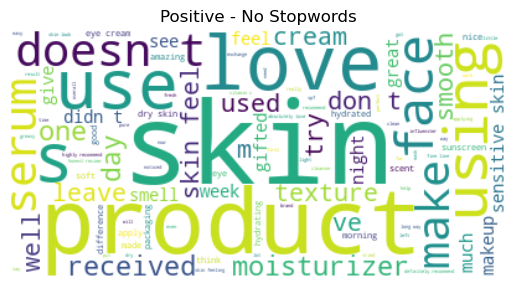

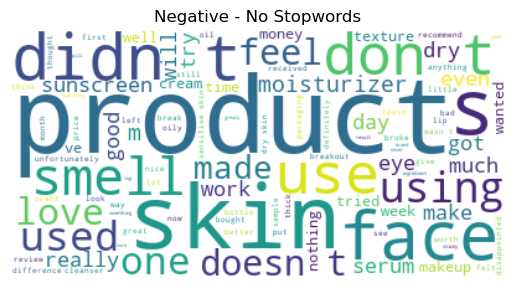

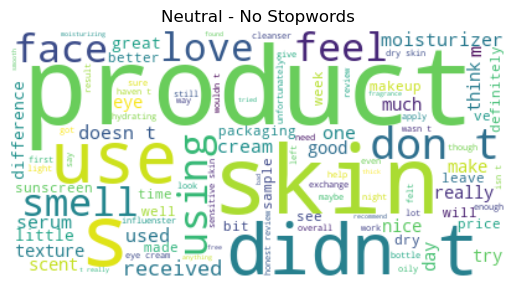

In [17]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

sentiments = ['positive', 'negative', 'neutral']

for sentiment in sentiments:
    sentiment_df = df[df['true_sentiment'] == sentiment]
    text = ' '.join(sentiment_df['review_text']).lower()

    # Use the STOPWORDS set from WordCloud to exclude common stopwords
    wc1 = WordCloud(stopwords=STOPWORDS, background_color="white", max_words=100).generate(text)

    plt.imshow(wc1, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"{sentiment.capitalize()} - No Stopwords")
    plt.show()


It has been observed that this review dataset contains a high frequency of product-related terms, such as 'skin', 'product', and 'face', across all sentiment categories. These words don't significantly influence predictions and should be classified as stopwords. 

Many reviews directly address the product; therefore, such information should be filtered out. While certain products might display predominantly positive or negative sentiments, including this data could introduce predefined biases or stereotypes about the product. Consequently, this could compromise the effectiveness of our sentiment classifier.

#### Only with Custom Stopwords

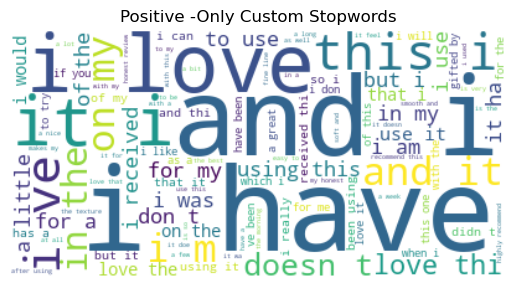

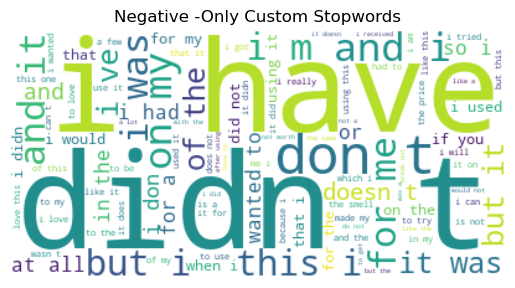

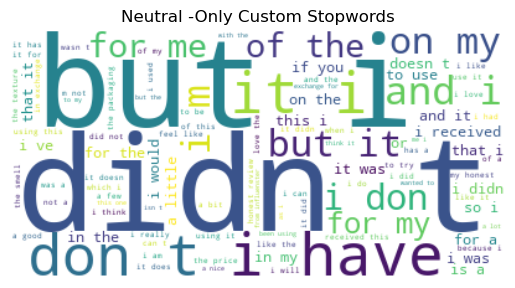

In [18]:
# draw wordcloud with custom stopword
custom_stopwords = {'skin','product','face','cream','serum','moisturizer','makeup','eye','sunscreen','eyes','products','s'}
sentiments = ['positive', 'negative', 'neutral']
for sentiment in sentiments:
    sentiment_df = df[df['true_sentiment'] == sentiment]
    text = ' '.join(sentiment_df['review_text']).lower()
    wc2 = WordCloud(background_color="white", max_words=100, stopwords=custom_stopwords).generate(text)
    plt.imshow(wc2, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"{sentiment.capitalize()} -Only Custom Stopwords")
    plt.show()

After removing the custom stopwords from the Sephora dataset, the word cloud is dominated by typical stopwords. These don't offer insights into the three distinct sentiment categories. Therefore, additional common English stopwords should be included.

#### custom & common english stopword

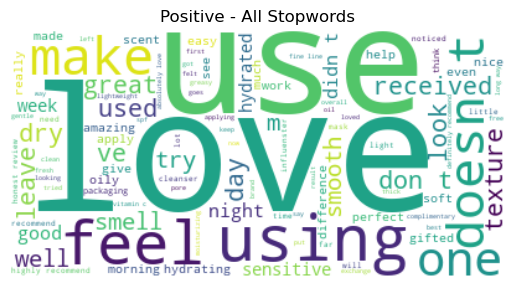

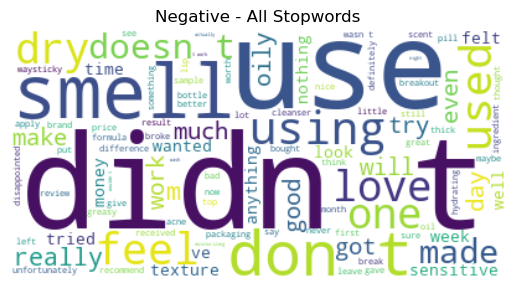

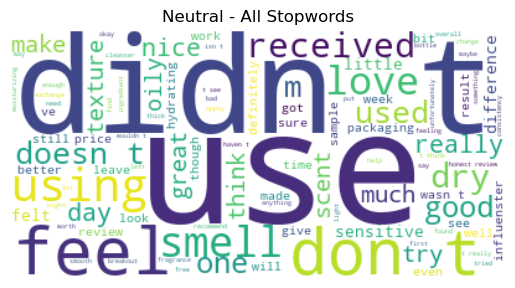

In [19]:
all_stopwords = STOPWORDS.union(custom_stopwords)
sentiments = ['positive', 'negative', 'neutral']
for sentiment in sentiments:
    sentiment_df = df[df['true_sentiment'] == sentiment]
    text = ' '.join(sentiment_df['review_text']).lower()
    wc3 = WordCloud(background_color="white", max_words=100, stopwords=all_stopwords).generate(text)
    plt.imshow(wc3, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"{sentiment.capitalize()} - All Stopwords")
    plt.show()

With the integration of these combined stopwords, the word cloud for the three sentiments displayed a noticeable distinction. These stopwords will be referenced later in the notebook and within the Python definition

### understanding target variables/lebal: rating & is_recommended

can is_recommended be used as target variables? 

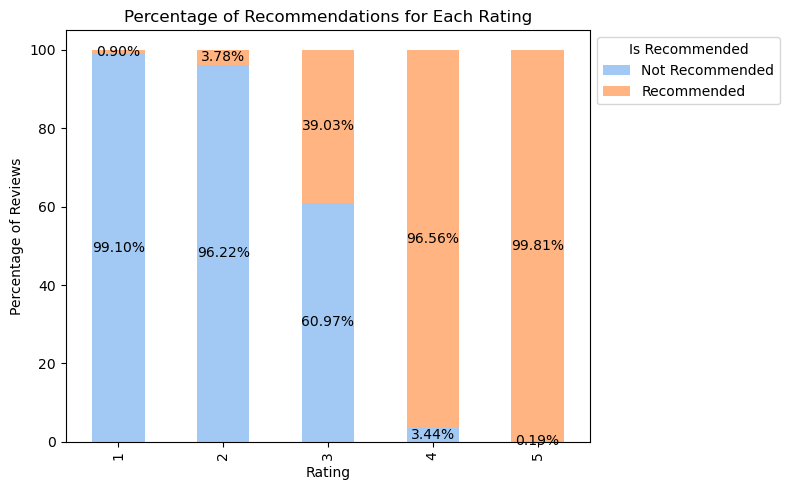

In [20]:
# understand % of is_recommended for different ratings
pivot_data = df.groupby(['rating', 'is_recommended']).size().unstack().fillna(0)
pivot_data_percentage = pivot_data.div(pivot_data.sum(axis=1), axis=0) * 100

# Plotting
ax = pivot_data_percentage.plot(kind='bar', stacked=True, figsize=(8, 5), color=sns.color_palette("pastel", len(pivot_data_percentage.columns)))
ax.set_title('Percentage of Recommendations for Each Rating')
ax.set_xlabel('Rating')
ax.set_ylabel('Percentage of Reviews')
ax.legend(title="Is Recommended", labels=["Not Recommended", "Recommended"], loc="upper left", bbox_to_anchor=(1, 1))

# Annotate with the percentage values
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    if height > 0:
        ax.text(x+width/2, y+height/2, f"{height:.2f}%", ha='center', va='center', color='black')

plt.tight_layout()
plt.show()

logically, user give higher ratings would more likely to recommend certain products 
- why some users recommend a product even if they give it a rating of 1? 
- why some don't recommend a product even if they give it a rating of 5?
- is is_recommended a valuable column to use? 

To achieve objectives above:
- Sample top 10 helpful(helpfulness) review where a user gave a rating of 1 but recommended the product.
- Sample top 10 helpful(helpfulness) review where a user gave a rating of 5 but didn't recommend the product.
- Generate word cloud for each type

In [21]:
# sample reviews with rating 1 but recommended
recommended_with_1 = df[(df['rating'] == 1) & (df['is_recommended'] == 1)]

# Display the top 10 reviews based on helpfulness
top_5_reviews = recommended_with_1.nlargest(5, 'helpfulness')
display(top_5_reviews[['review_text', 'review_title', 'product_name', 'brand_name', 'price_usd']])

review_text  \
38428  Love the original, hate the refill. Purchased the refill to save some money and plastic. I followed the instructions to replace the refill and The pump no longer works and I can’t unscrew the refill to get the product out by hand. I’ve essentially wasted the $42 and my local Sephora doesn’t carry this product so I can’t exchange it. I’m just going to see if I can break the container open to salvage some of my purchase. Don’t buy the refill.   
42566                                                                                                                                                     It feels very cooling when first applied, but that’s it. It doesnt work, it doesn’t depuff, it doesn’t anything. I’ve been using it for months and I haven’t seen any change at all. It does absorb easily and the gel like texture makes it easy to apply in specific areas, but it doesn’t do anything.   
54137                                                                                                                                                                                                                                                                                                            I didn’t use this product because it did not have a safety seal when you opened it. It was just there. I prefer not to put product around my eyes.   
58368                                                                                                                                                                                                                                              I do not like the knew packaging. A lot more formula comes out, I feel like I use more product now then before before and the bottle keeps opening all together I constantly have to be Putting it back together   
62118                                                                                                                                   The product is perfect but imagine purchasing the item and have a complete reaction due to the product being expired!! Thank you Sephora for not pulling your expired items off the shelf. Expectation date May 2022 and it’s almost 2023. I returned the product for an exchange but all of them were expired!Speechless!!   

                    review_title                              product_name  \
38428                        NaN  Barrier+ Triple Lipid-Peptide Face Cream   
42566               Doesn't work    Caffeine 5% + EGCG Depuffing Eye Serum   
54137            I didn't use it       Advanced Night Repair Eye Gel-Cream   
58368     I miss the old formula         C-Firma Fresh Vitamin-C Day Serum   
62118  Check The Expiration Date      CC+ Cream Oil-Free Matte with SPF 40   

           brand_name  price_usd  
38428         Skinfix       54.0  
42566    The Ordinary        8.9  
54137    Estée Lauder       72.0  
58368  Drunk Elephant       78.0  
62118    IT Cosmetics       44.0

In [22]:
# sample reviews with rating 5 but not recommended
not_recommended_with_5 = df[(df['rating'] == 5) & (df['is_recommended'] == 0)]

# Display the top 10 reviews based on helpfulness
top_5_reviews_not_recommended = not_recommended_with_5.nlargest(5, 'helpfulness')
display(top_5_reviews_not_recommended[['review_text', 'review_title', 'product_name', 'brand_name', 'price_usd']])


review_text  \
1535                                                                                                                            Love this cleanser, use it every day. Very gentle on dry skin. Doesn’t take off my makeup super well so I use it as the second part of a double cleanse if I wear makeup.   
1556                                                                                                                                                                                                                                      Soft and nice. Smells almost neutral. Does not dry out my skin.   
4109   I have very sensitive, combination skin. This cleanser is the only one I’ve been able to find that has cleared my skin after one use, and keeps my skin under control all around. It’s gentle, but really deeply cleanses without over stripping it. I keep coming back to it time and time again.   
7637                                                                                                                                  Loved it deff worth the money for the full size. I don’t use it often but when my skin just need a gentle scrub this is my go to. It feels so smooth & clean after.   
14584                                                                                                                                                                          Best moisturizer for my combination skin. I’ve been using for a little over a year now and my skin has changed drastically   

      review_title                                          product_name  \
1535           NaN                    Soy Hydrating Gentle Face Cleanser   
1556           NaN                    Soy Hydrating Gentle Face Cleanser   
4109         GO TO                        Superfood Antioxidant Cleanser   
7637      Loved it                    Mini Daily Microfoliant Exfoliator   
14584          NaN  The Water Cream Oil-Free Pore Minimizing Moisturizer   

                brand_name  price_usd  
1535                 fresh       39.0  
1556                 fresh       39.0  
4109   Youth To The People       39.0  
7637           Dermalogica       18.0  
14584               Tatcha       70.0

create word cloud to understand high frequency terms

In [23]:
# Define a function to draw the word clouds
def get_word_cloud_text(df):
    return " ".join(review for review in df['review_text'])

def draw_word_cloud(text, ax, title):
    wordcloud = WordCloud(background_color="white", max_words=100, stopwords=all_stopwords).generate(text)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis("off")
    ax.set_title(title)

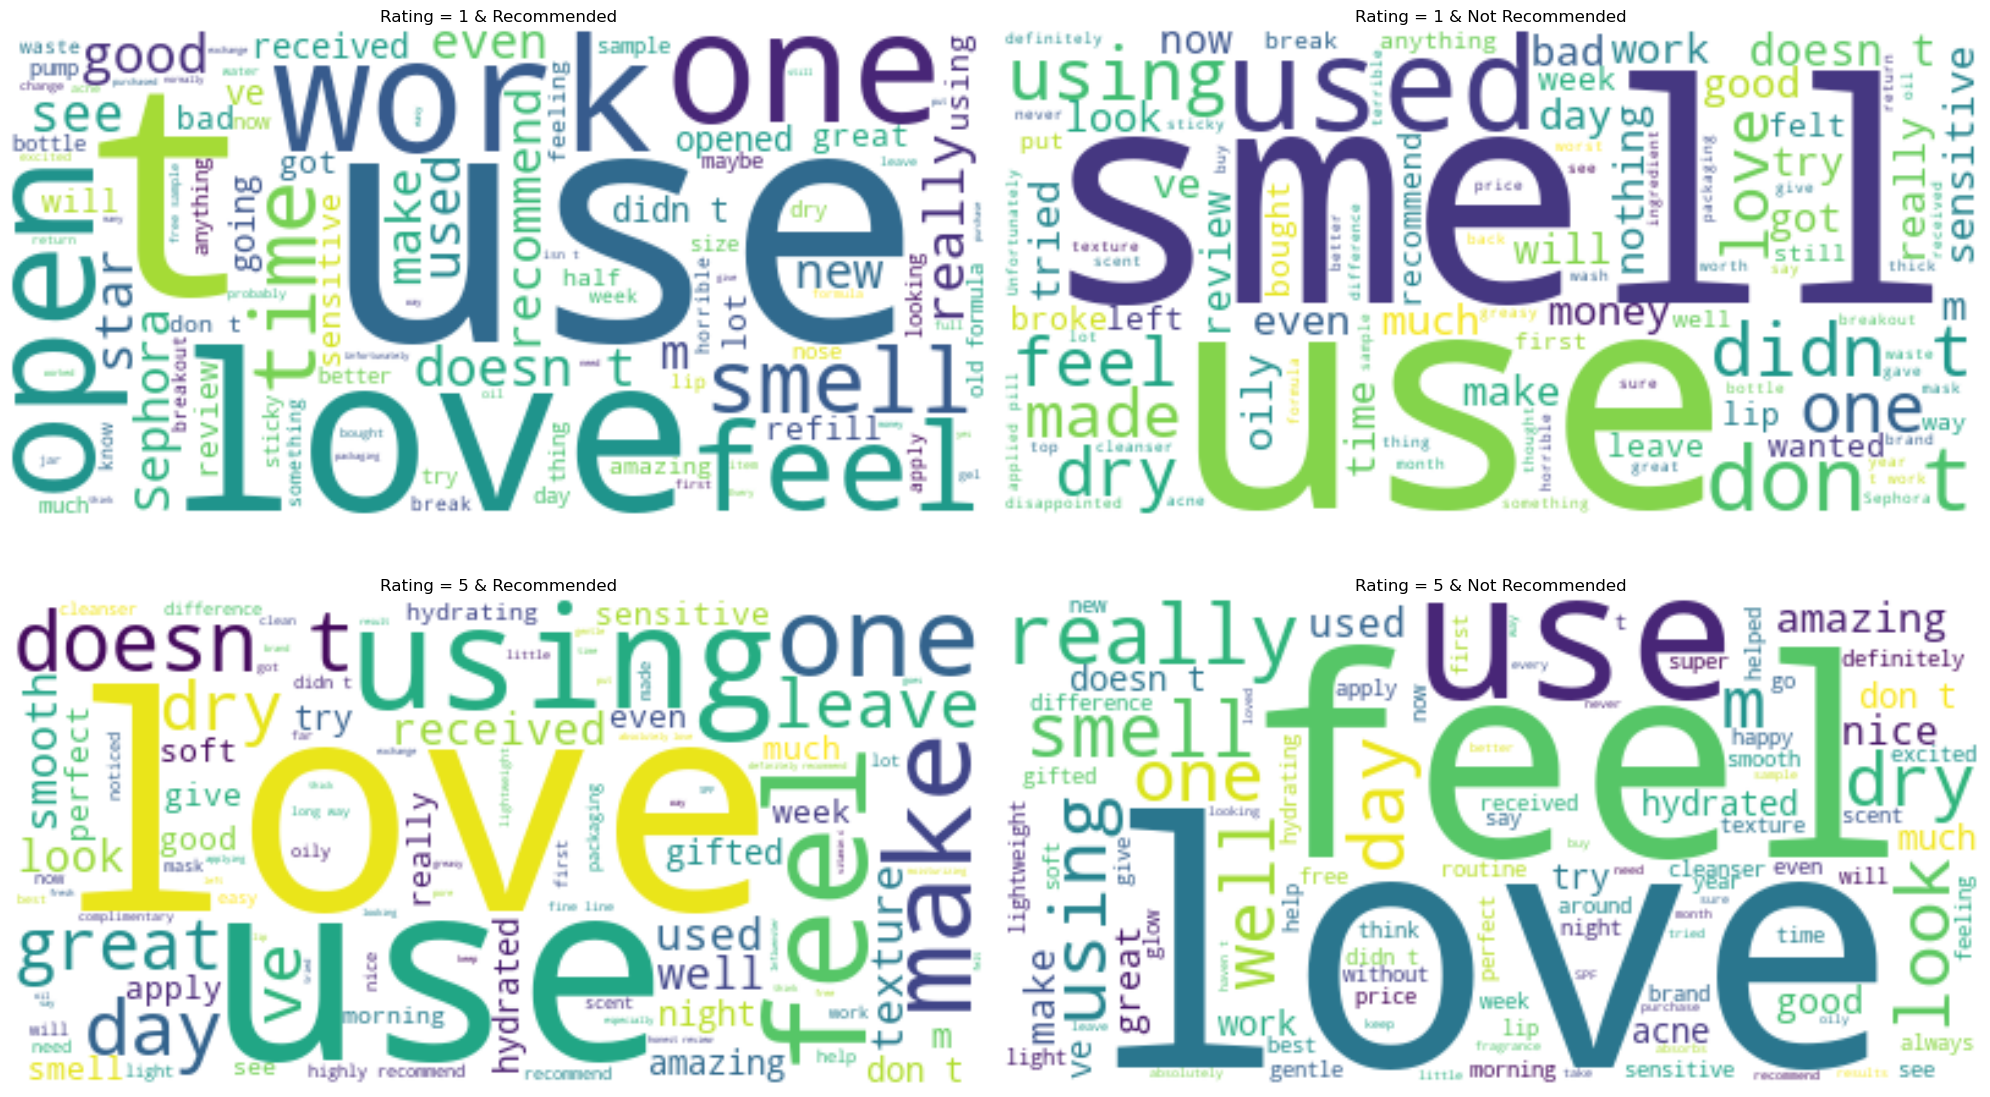

In [24]:
# get dataframe
recommended_with_5 = df[(df['rating'] == 5) & (df['is_recommended'] == 1)]
not_recommended_with_1 = df[(df['rating'] == 1) & (df['is_recommended'] == 0)]

# draw word cloud
fig, axs = plt.subplots(2, 2, figsize=(20, 12))

draw_word_cloud(get_word_cloud_text(recommended_with_1), axs[0, 0], "Rating = 1 & Recommended")
draw_word_cloud(get_word_cloud_text(not_recommended_with_1), axs[0, 1], "Rating = 1 & Not Recommended")
draw_word_cloud(get_word_cloud_text(recommended_with_5), axs[1, 0], "Rating = 5 & Recommended")
draw_word_cloud(get_word_cloud_text(not_recommended_with_5), axs[1, 1], "Rating = 5 & Not Recommended")

plt.tight_layout()
plt.show()

looking at the sample reviews and word cloud above: 
- rating = 1 but recommended: usually has no issue with the product itself, but either services, condition of the product etc. this group of reviews should be flagged out and feedback to the relevent stakeholders. 
- rating = 5 but not recommended: generally does not show bad emotions/sentiments about the products and related services, potentially a default value = 0 when people doesnt leave an input, or put wrongly. 
- is_recommended is not a good feature to used as target variables

### understanding target variables/lebal: rating = 3

zoom onto reviews with ratings 3
- it observed that half of 3 review recommend, and the half does not
- current classfier failed to predict netural labels well
- understand the true sentiment
- is such data noise to the dataset?

To achieve above:
- some sample data
- wordcloud

In [25]:
# Filtering out reviews with ratings of 3
reviews_with_3 = df[df['rating'] == 3]

# Fetching top 10 samples for both categories
recommended_samples = reviews_with_3[reviews_with_3['is_recommended'] == 1].sample(10)
not_recommended_samples = reviews_with_3[reviews_with_3['is_recommended'] == 0].sample(10)


In [26]:
# Display the samples
pd.set_option('display.max_colwidth', None)

print("Top 10 Sample Reviews with Rating of 3 that are Recommended:")
display(recommended_samples[['review_text', 'is_recommended', 'true_sentiment']])

print("\nTop 10 Sample Reviews with Rating of 3 that are Not Recommended:")
display(not_recommended_samples[['review_text', 'is_recommended', 'true_sentiment']])

Top 10 Sample Reviews with Rating of 3 that are Recommended:


review_text  \
59636   I received this product from Influenster in exchange for an honest review. I have been using this product for the past two weeks and I am fairly pleased with the results. It has left my skin feeling extra soft and moisturized, but I wouldn’t say my skin is necessarily glowing. Also the consistency of this product is hard to work with because it soaks into the skin very quickly which makes it difficult to get an even application, and it is very watery.   
154755                                                                                                                                                                                                                                                                                                                                                                                                             It hydrates my skin very well and allows moisture retention.   
49207                                                                                                                                                                                                                                                                                                #freeproduct #trywithtopbox I liked this product because it is easy to apply but I did not see any difference after using my sample. I can say that it was not irritating.   
6394                              This cream was amazing when I first started using it. It was great and evening out my skin tone (which is red prone) and gave me a nice glow. Sadly after a couple weeks of using it I opened it one day and it was completely separated. As in there was liquid in the jar and the remaining cream was much thicker and a weird consistency. I kept using it but the cream wasn’t as easy to blend in and before and had a different finish.   
40686                                                                                                      I have eczema on my face and this product was suggested to me by a Sephora employee who said it was really hydrating as I wanted to try something new as nothing was really working that well for me except La Mer and I cant always afford that. This product is so-so. It feels hydrating but once it’s on the hydration goes away. It is just okay in my opinion.   
104373                                                                                                                       I don’t like how greasy it feels on my face as I rub it in, but it sure does remove all my makeup in one go! Also it makes your eyes a bit blurry and foggy for a while afterwards. With a cleansing oil I find it’s more convenient than something like this as it is more slippery and easier to massage in. Also makes it easier to avoid eyes.   
43876                                                                                                            A neutral, unremarkable moisturizer for a very good price. I use it as a non-greasy, hypoallergenic moisturizer for hands and face when I’m skin cycling and need something that won’t react with my skin. I stopped using it for a few years, bought it again, and remembered why I stopped using it; it doesn’t really stand out! But can’t beat that price.   
59365                                                                                                                                                                                                                                                                                                                                                                                                             This mask is fun but I dont know how much it impacts my skin.   
74904                                                                                                                                                                                                                           I loved the idea of intro


Top 10 Sample Reviews with Rating of 3 that are Not Recommended:


review_text  \
6568                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           Nice in theory. It clung to every dry spot on my face. It was quote heavy & like I meantioned clung to any dry patch on my face & was very noticeable. It might work for you if you have pretty good skin already.   
126444                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            I really wanted to love this, I love Fenty and anything cherry flavored. This is just ok. It smells like a cross between cherry and play-dough, it’s more like a gloss then a oil. Not much shine payoff either. It’s overhyped and priced and I don’t get moisturizing at all.   
131402                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             I was very hopeful about this product as this was my first sunscreen stick. Eventhough the product provides great protection and is easy to use, it is significantly oily and didn’t work well for my combination skin. If thats not a problem for you, I’d definitely recommend this product.   
46327   I received this in exchange for my honest opinion from @influenster. The key Ingredients in this cream boast many benefits such as fighting the look of wrinkles by boosting natural collagen, which helps strengthen skin’s natural support structure. It contains Sigesbeckia  orientalis extract: A powerful procollagen extract, prized for helping skin maintain its natural density.Hyaluronic acid which helps flood your skin with hydration and helps restore suppleness and visibly smooth fine, dry lines. However, despite those promising ingredients it fell short of making an actual impression on my fine lines around my eyes. The texture is creamy yet thin. It is not too thick and spreads evenly on your eyes. I prefer scented products but can appreciate that it is scent free especially for an eye product. I love Clinique’s other products but will be passing on this one.   
135312                                                                                                                                                                                                                                                                                                                                                                                                                                                       

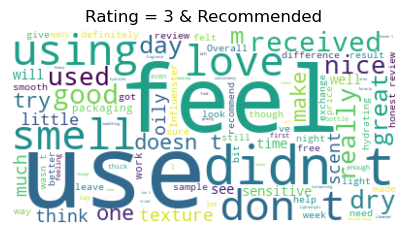

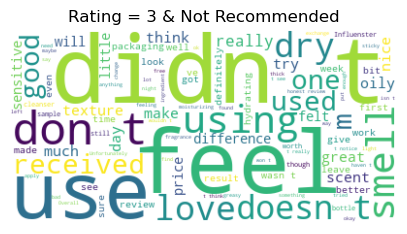

In [27]:
def generate_word_cloud(df, title):
    text = " ".join(review for review in df['review_text'])
    wordcloud = WordCloud(background_color="white", max_words=100,stopwords=all_stopwords).generate(text)
    plt.figure(figsize=(5, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title)
    plt.show()

# Generate word clouds
generate_word_cloud(reviews_with_3[reviews_with_3['is_recommended'] == 1], "Rating = 3 & Recommended")
generate_word_cloud(reviews_with_3[reviews_with_3['is_recommended'] == 0], "Rating = 3 & Not Recommended")


review with rating of 3, seems to have both negtive and positive feedbacks. Thus such reviews could be recognozied as noise to be excluded
- true neutral 
- mixture of feelings, postive towards certain asepect, negative towards certain aspect 
- showing postive or negtive sentiments 

In [28]:
# create a new dataframe df_no_3 to store only positive and negative feedbacks
df_no_3 = df[df['rating'] != 3]
pd.set_option('display.max_colwidth', 50)
df_no_3.head(3)


rating  is_recommended  helpfulness submission_time  \
1       2             0.0     0.500000      2022-12-31   
2       5             1.0     1.000000      2022-12-31   
3       4             1.0     0.333333      2022-12-31   

                                         review_text         review_title  \
1  Might as well be putting on Vaseline because I...  Where’s the smell??   
2  Love this lip mask nothing else will do Aquaph...            Must buy!   
3  I really enjoy this product! Amazing smell and...         Lovely smell   

   length                                       product_name brand_name  \
1     160  Lip Sleeping Mask Intense Hydration with Vitam...    LANEIGE   
2      92  Lip Sleeping Mask Intense Hydration with Vitam...    LANEIGE   
3     148  Lip Sleeping Mask Intense Hydration with Vitam...    LANEIGE   

   price_usd primary_category      secondary_category tertiary_category  \
1       24.0         Skincare  Lip Balms & Treatments               NaN   
2       24.0         Skincare  Lip Balms & Treatments               NaN   
3       24.0         Skincare  Lip Balms & Treatments               NaN   

  true_sentiment                                  reviews_processed prediction  
1       negative  might as well be putting on vaseline because i...   negative  
2       positive  love this lip mask nothing else will do aquaph...   negative  
3       positive  i really enjoy this product amazing smell and ...   positive

### understanding target variables/lebal: unbalanced data

In [29]:
df_no_3.columns

Index(['rating', 'is_recommended', 'helpfulness', 'submission_time',
       'review_text', 'review_title', 'length', 'product_name', 'brand_name',
       'price_usd', 'primary_category', 'secondary_category',
       'tertiary_category', 'true_sentiment', 'reviews_processed',
       'prediction'],
      dtype='object')

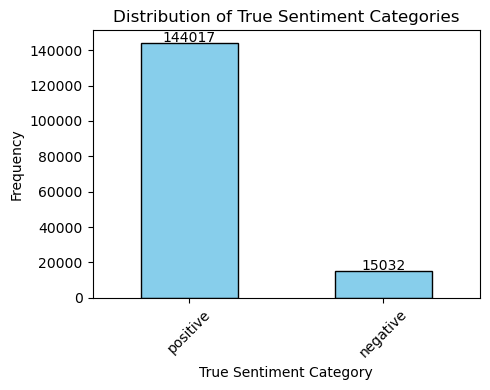

In [30]:
# check distribution of sentiments
value_counts = df_no_3['true_sentiment'].value_counts()

fig, ax = plt.subplots(figsize=(5, 4))
value_counts.plot(kind='bar', color='skyblue', edgecolor='black', ax=ax)
ax.set_title('Distribution of True Sentiment Categories')
ax.set_xlabel('True Sentiment Category')
ax.set_ylabel('Frequency')
plt.xticks(rotation=45) 

# Add count numbers on top of each bar
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 4), textcoords='offset points')

plt.tight_layout()  

# Display the plot
plt.show()


In [31]:
# undersampling 

# Separate majority and minority classes
df_majority = df_no_3[df_no_3['true_sentiment'] == 'positive']
df_minority = df_no_3[df_no_3['true_sentiment'] == 'negative']

# Undersample the majority class
df_majority_undersampled = df_majority.sample(n=len(df_minority), random_state=42)
df_undersampled = pd.concat([df_majority_undersampled, df_minority], axis=0)
df_undersampled = df_undersampled.sample(frac=1, random_state=2023).reset_index(drop=True)


In [32]:
# Subtract the undersampled majority data from the entire majority dataset
df_majority_not_used = df_majority.drop(df_majority_undersampled.index)

# If you want to store it as a CSV for future use:
# df_majority_not_used.to_csv('majority_not_used.csv', index=False)


## Model Improvement 

multiple training explorations with different: 
- training data & labels
- preprocesser
- word embedding
- features

### exploration on different training data and labels

#### train with only positive and negative labels 
- target variables: true sentiments (<=2: negative, >=4: positive)
- input data: no dup data, still imbalanced
- features: only 'review_text'
- preprocessor: lowercase
- vectorizer: count

In [33]:
# training data using df_no_3
preprocessors = ['lowercase']
nb_classifier = NaiveBayesClassifier(data=df_no_3, text_col='review_text', preprocessors=preprocessors)
train_metrics, test_metrics = nb_classifier.train(vectorizer_type='count', use_additional_features=False)

/Users/ljyjiayi/Library/CloudStorage/OneDrive-SingaporeManagementUniversity/609 Text/text_analytics/sentiment_classifier/naive_bayes_utils.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['reviews_processed'] = self.data[self.text_col].apply(self.apply_preprocessors)


In [34]:
# get the basic evaluation/accuracy metrics
print(f"Train Accuracy: {train_metrics['accuracy']:.5f}")
print(f"Test Accuracy: {test_metrics['accuracy']:.5f}")

Train Accuracy: 0.94982
Test Accuracy: 0.94711


In [35]:
# set column labels
labels = sorted(nb_classifier.data['true_sentiment'].unique())
index_labels = [f"True {label}" for label in labels]
column_labels = [f"Predicted {label}" for label in labels]

# get train evaluation for train set
print("\nTrain:")
nb_classifier.display_results(train_metrics)

confusion_df = pd.DataFrame(train_metrics['confusion_mat'], index=index_labels, columns=column_labels)
print("\nConfusion Matrix:")
confusion_df


Train:
accuracy: 0.94982
precision: 0.95205
recall: 0.94982
f1: 0.95078
f2: 0.95026

Confusion Matrix:


Predicted negative  Predicted positive
True negative                7101                1985
True positive                2804               83539

In [36]:
# get train evaluation for test set
print("\nTest:")
nb_classifier.display_results(test_metrics)

confusion_df = pd.DataFrame(test_metrics['confusion_mat'], index=index_labels, columns=column_labels)
print("\nConfusion Matrix:")
confusion_df


Test:
accuracy: 0.94711
precision: 0.94746
recall: 0.94711
f1: 0.94728
f2: 0.94718

Confusion Matrix:


Predicted negative  Predicted positive
True negative                4307                1639
True positive                1726               55948

In [37]:
new_entry = {
    'Name': 'NB Model',
    'Train Accuracy': train_metrics['accuracy'],
    'Train Precision': train_metrics['precision'],
    'Train Recall': train_metrics['recall'],
    'Train F1': train_metrics['f1'],
    'Train F2': train_metrics['f2'],
    'Train Confusion Matrix': train_metrics['confusion_mat'].tolist(), 
    'Test Accuracy': test_metrics['accuracy'],
    'Test Precision': test_metrics['precision'],
    'Test Recall': test_metrics['recall'],
    'Test F1': test_metrics['f1'],
    'Test F2': test_metrics['f2'],
    'Test Confusion Matrix': test_metrics['confusion_mat'].tolist(), 
    'Preprocesser': preprocessors, 
    'Vectorizer': 'count',
    'Classifier': 'Naive Bayes',
    'Feature': 'review_text',
    'Target': 'positive, neutral',
    'remarks': 'no duplicates reviews, only positive and negative reviews'
}

new_entry


{'Name': 'NB Model',
 'Train Accuracy': 0.9498160936402981,
 'Train Precision': 0.9520464565486026,
 'Train Recall': 0.9498160936402981,
 'Train F1': 0.9507786304591752,
 'Train F2': 0.9502613298173023,
 'Train Confusion Matrix': [[7101, 1985], [2804, 83539]],
 'Test Accuracy': 0.9471078277271299,
 'Test Precision': 0.9474601378915405,
 'Test Recall': 0.9471078277271299,
 'Test F1': 0.9472799362399333,
 'Test F2': 0.9471782687975793,
 'Test Confusion Matrix': [[4307, 1639], [1726, 55948]],
 'Preprocesser': ['lowercase'],
 'Vectorizer': 'count',
 'Classifier': 'Naive Bayes',
 'Feature': 'review_text',
 'Target': 'positive, neutral',
 'remarks': 'no duplicates reviews, only positive and negative reviews'}

In [38]:
results_list.append(new_entry)
# results_list

In [39]:
# sample incorrect prediction 
visualizer = NaiveBayesVisualization(nb_classifier)
visualizer.display_incorrect_samples(2)

Review: Love this lip mask nothing else will do Aquaphor and Vaseline just aren’t as moisturizing as this mask is I recommend it to everyone I know￼
Review Procrssed: love this lip mask nothing else will do aquaphor and vaseline just aren’t as moisturizing as this mask is i recommend it to everyone i know￼
Actual Sentiment: positive
Predicted Sentiment: negative

Review: I had chapped lips suddenly (normally not a problem for me) and after several days of lip balm/chapstick, they only started healing once I started using this. I had a sample from a reward or birthday gift. I will definitely keep it on hand for the future.
Review Procrssed: i had chapped lips suddenly normally not a problem for me and after several days of lip balmchapstick they only started healing once i started using this i had a sample from a reward or birthday gift i will definitely keep it on hand for the future
Actual Sentiment: positive
Predicted Sentiment: negative

Review: I’ve used it for 2 months and honestl

/Users/ljyjiayi/Library/CloudStorage/OneDrive-SingaporeManagementUniversity/609 Text/text_analytics/sentiment_classifier/naive_bayes_utils.py:212: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['prediction'] = self.validator.predict_batch(self.data['reviews_processed'].tolist())


The first and second review seems very positive, and there doesn't seem to be any overtly negative words that could have led to misclassification. The use of terms like "Aquaphor" and "Vaseline" might have been associated with negative sentiments in the training data, leading to the incorrect prediction.

The third review is negative in nature but contains positive words like "love" and "gloss." The model might have weighed these words more heavily leading to the misclassification. The last review has a mix of positive and negative sentiments, making it a bit trickier to classify. Words like "decent" could have contributed to the misclassification.

#### train with only positive and negative labels, filter out inconsistent is_recommended col 
- target variables: true sentiments (<=2: negative, >=4: positive)
- input data: no dup data, still imbalanced
- features: only 'review_text'
- preprocessor: lowercase
- vectorizer: count

In [40]:
positive_and_recommended = df_no_3[(df_no_3['true_sentiment'] == 'positive') & (df_no_3['is_recommended'] == 1)]
negative_and_not_recommended = df_no_3[(df_no_3['true_sentiment'] == 'negative') & (df_no_3['is_recommended'] == 0)]

df_cleaned = pd.concat([positive_and_recommended, negative_and_not_recommended])


In [41]:
preprocessors = ['lowercase']
clean_nb_classifier = NaiveBayesClassifier(data=df_cleaned, text_col='review_text', preprocessors=preprocessors)
train_metrics, test_metrics = clean_nb_classifier.train(vectorizer_type='count', use_additional_features=False)

In [42]:
# get the basic evaluation/accuracy metrics
print(f"Train Accuracy: {train_metrics['accuracy']:.5f}")
print(f"Test Accuracy: {test_metrics['accuracy']:.5f}")

Train Accuracy: 0.95152
Test Accuracy: 0.94952


In [43]:
# set column labels
labels = sorted(clean_nb_classifier.data['true_sentiment'].unique())
index_labels = [f"True {label}" for label in labels]
column_labels = [f"Predicted {label}" for label in labels]

# get train evaluation for train set
print("\nTrain:")
clean_nb_classifier.display_results(train_metrics)

confusion_df = pd.DataFrame(train_metrics['confusion_mat'], index=index_labels, columns=column_labels)
print("\nConfusion Matrix:")
confusion_df


Train:
accuracy: 0.95152
precision: 0.95323
recall: 0.95152
f1: 0.95228
f2: 0.95186

Confusion Matrix:


Predicted negative  Predicted positive
True negative                6906                1967
True positive                2610               82928

In [44]:
# get train evaluation for test set
print("\nTest:")
clean_nb_classifier.display_results(test_metrics)

confusion_df = pd.DataFrame(test_metrics['confusion_mat'], index=index_labels, columns=column_labels)
print("\nConfusion Matrix:")
confusion_df


Test:
accuracy: 0.94952
precision: 0.95020
recall: 0.94952
f1: 0.94984
f2: 0.94966

Confusion Matrix:


Predicted negative  Predicted positive
True negative                4312                1505
True positive                1672               55452

In [45]:
new_entry = {
    'Name': 'clean NB Model',
    'Train Accuracy': train_metrics['accuracy'],
    'Train Precision': train_metrics['precision'],
    'Train Recall': train_metrics['recall'],
    'Train F1': train_metrics['f1'],
    'Train F2': train_metrics['f2'],
    'Train Confusion Matrix': train_metrics['confusion_mat'].tolist(), 
    'Test Accuracy': test_metrics['accuracy'],
    'Test Precision': test_metrics['precision'],
    'Test Recall': test_metrics['recall'],
    'Test F1': test_metrics['f1'],
    'Test F2': test_metrics['f2'],
    'Test Confusion Matrix': test_metrics['confusion_mat'].tolist(), 
    'Preprocesser': preprocessors, 
    'Vectorizer': 'count',
    'Classifier': 'Naive Bayes',
    'Feature': 'review_text',
    'Target': 'positive, neutral',
    'remarks': 'no duplicates reviews, clean data, only positive and negative reviews'
}

# new_entry


In [46]:
results_list.append(new_entry)
# results_list

#### train with undersampling dataset
- target variables: true sentiments (<=2: negative, >=4: positive)
- input data: no dup data, undersampled to reach balanced data
- features: only 'review_text'
- preprocessor: lowercase
- vectorizer: count

In [47]:
# training data using df_undersampled
preprocessors = ['lowercase']
undersample_nb_classifier = NaiveBayesClassifier(data=df_undersampled, text_col='review_text', preprocessors=preprocessors)
train_metrics, test_metrics = undersample_nb_classifier.train(vectorizer_type='count', use_additional_features=False)

In [48]:
# get the basic evaluation/accuracy metrics
print(f"Train Accuracy: {train_metrics['accuracy']:.5f}")
print(f"Test Accuracy: {test_metrics['accuracy']:.5f}")

Train Accuracy: 0.92854
Test Accuracy: 0.91452


In [49]:
# set column labels
labels = sorted(undersample_nb_classifier.data['true_sentiment'].unique())
index_labels = [f"True {label}" for label in labels]
column_labels = [f"Predicted {label}" for label in labels]

# get train evaluation for train set
print("\nTrain:")
undersample_nb_classifier.display_results(train_metrics)

confusion_df = pd.DataFrame(train_metrics['confusion_mat'], index=index_labels, columns=column_labels)
print("\nConfusion Matrix:")
confusion_df


Train:
accuracy: 0.92854
precision: 0.92879
recall: 0.92854
f1: 0.92853
f2: 0.92859

Confusion Matrix:


Predicted negative  Predicted positive
True negative                8457                 536
True positive                 753                8292

In [50]:
# get train evaluation for test set
print("\nTest:")
undersample_nb_classifier.display_results(test_metrics)

confusion_df = pd.DataFrame(test_metrics['confusion_mat'], index=index_labels, columns=column_labels)
print("\nConfusion Matrix:")
confusion_df


Test:
accuracy: 0.91452
precision: 0.91472
recall: 0.91452
f1: 0.91450
f2: 0.91456

Confusion Matrix:


Predicted negative  Predicted positive
True negative                5593                 446
True positive                 582                5405

In [51]:
new_entry = {
    'Name': 'Undersampled Model',
    'Train Accuracy': train_metrics['accuracy'],
    'Train Precision': train_metrics['precision'],
    'Train Recall': train_metrics['recall'],
    'Train F1': train_metrics['f1'],
    'Train F2': train_metrics['f2'],
    'Train Confusion Matrix': train_metrics['confusion_mat'].tolist(), 
    'Test Accuracy': test_metrics['accuracy'],
    'Test Precision': test_metrics['precision'],
    'Test Recall': test_metrics['recall'],
    'Test F1': test_metrics['f1'],
    'Test F2': test_metrics['f2'],
    'Test Confusion Matrix': test_metrics['confusion_mat'].tolist(), 
    'Preprocesser': preprocessors, 
    'Vectorizer': 'count',
    'Classifier': 'Naive Bayes',
    'Feature': 'review_text',
    'Target': 'positive, neutral',
    'remarks': 'no duplicates reviews, only positive and negative reviews, balanced data with undersampling'
}

# new_entry


In [52]:
results_list.append(new_entry)
# results_list

In [53]:
# Extract the review texts and true sentiments
X_test = df_majority_not_used['review_text'].tolist()
y_test = df_majority_not_used['true_sentiment']

from sklearn.metrics import confusion_matrix

validator=Validator(undersample_nb_classifier)
predictions  = validator.predict_batch(texts=X_test)


In [54]:
# Compute the confusion matrix
matrix = confusion_matrix(y_test, predictions)

# Display the confusion matrix
print(matrix)

[[     0      0]
 [ 13494 115491]]


#### Conclusion

1. Normal Model:
- performs better on both training and testing data compared to the undersampling model
- difference between the training and testing metrics is less pronounced, suggesting that the model is generalizing better to unseen data than the undersampling model.
- But tends to misclassify negative reviews as positive, likely due to the imbalanced data.

2. Clean NB Model:
- slightly better performance than the normal model on both training and testing datasets.
- minimal difference between train and test metrics indicates its capability to generalize well to unseen data.

3. Undersampling Model:
- slightly lower metrics than the normal model but better balanced in terms of precision and recall.
- difference between train and test metrics is higher, this suggests a bit more overfitting than undersampling model
- better performance towards negative sentiments, 

Left Over Positive Reviews: about 10% positive reviews were misclassified as negative. This might be due to the nature of the undersampling method or the inherent limitations of the Naive Bayes classifier.

4. Choosing the Model: Clean NB Model

In the competitive e-commerce sphere, Sephora values customer feedback. The normal model, with its higher accuracy and larger pool size, aligns better with Sephora's aim to cater to a broader audience. The clean NB Model, being a refined version of the normal model, may offer an even better representation of customer sentiments. By identifying and emphasizing what's working well, the company aims to further delight its satisfied customers. The undersampling model, while effective at highlighting criticisms, leans too heavily on the negative, potentially missing out on a larger pool of target audience.

### exploration with different stopwords preprocessor

#### train with stopword and lowercase preprocessor
- target variables: true sentiments (<=2: negative, >=4: positive)
- input data: all non-dup data
- features: only 'review_text'
- preprocessor: lowercase, stopword
- vectorizer: count

In [55]:
# training data using df_no_3
preprocessors = ['lowercase','stopword']
sw_nb_classifier = NaiveBayesClassifier(data=df_cleaned, text_col='review_text', preprocessors=preprocessors)
train_metrics, test_metrics = sw_nb_classifier.train(vectorizer_type='count', use_additional_features=False)

In [56]:
# get the basic evaluation/accuracy metrics
print(f"Train Accuracy: {train_metrics['accuracy']:.5f}")
print(f"Test Accuracy: {test_metrics['accuracy']:.5f}")

Train Accuracy: 0.95042
Test Accuracy: 0.94811


In [57]:
# set column labels
labels = sorted(sw_nb_classifier.data['true_sentiment'].unique())
index_labels = [f"True {label}" for label in labels]
column_labels = [f"Predicted {label}" for label in labels]

# get train evaluation for train set
print("\nTrain:")
sw_nb_classifier.display_results(train_metrics)

confusion_df = pd.DataFrame(train_metrics['confusion_mat'], index=index_labels, columns=column_labels)
print("\nConfusion Matrix:")
confusion_df


Train:
accuracy: 0.95042
precision: 0.94931
recall: 0.95042
f1: 0.94981
f2: 0.95020

Confusion Matrix:


Predicted negative  Predicted positive
True negative                6296                2577
True positive                2104               83434

In [58]:
# get train evaluation for test set
print("\nTest:")
sw_nb_classifier.display_results(test_metrics)

confusion_df = pd.DataFrame(test_metrics['confusion_mat'], index=index_labels, columns=column_labels)
print("\nConfusion Matrix:")
confusion_df


Test:
accuracy: 0.94811
precision: 0.94591
recall: 0.94811
f1: 0.94677
f2: 0.94767

Confusion Matrix:


Predicted negative  Predicted positive
True negative                3870                1947
True positive                1319               55805

In [59]:
new_entry = {
    'Name': 'Normal Stopword Model',
    'Train Accuracy': train_metrics['accuracy'],
    'Train Precision': train_metrics['precision'],
    'Train Recall': train_metrics['recall'],
    'Train F1': train_metrics['f1'],
    'Train F2': train_metrics['f2'],
    'Train Confusion Matrix': train_metrics['confusion_mat'].tolist(), 
    'Test Accuracy': test_metrics['accuracy'],
    'Test Precision': test_metrics['precision'],
    'Test Recall': test_metrics['recall'],
    'Test F1': test_metrics['f1'],
    'Test F2': test_metrics['f2'],
    'Test Confusion Matrix': test_metrics['confusion_mat'].tolist(), 
    'Preprocesser': preprocessors, 
    'Vectorizer': 'count',
    'Classifier': 'Naive Bayes',
    'Feature': 'review_text',
    'Target': 'positive, neutral',
    'remarks': 'no duplicates reviews, cleaned model, undersampling data, only positive and negative reviews'
}

# new_entry


In [60]:
results_list.append(new_entry)
# results_list

#### train with custom_stopword and lowercase preprocessor
- target variables: true sentiments (<=2: negative, >=4: positive)
- input data: all non-dup data
- features: only 'review_text'
- preprocessor: lowercase, custom_stopword
- vectorizer: count

In [61]:
# training data using df_no_3
preprocessors = ['lowercase','custom_stopword']
cus_sw_nb_classifier = NaiveBayesClassifier(data=df_cleaned, text_col='review_text', preprocessors=preprocessors)
train_metrics, test_metrics = cus_sw_nb_classifier.train(vectorizer_type='count', use_additional_features=False)

In [62]:
# get the basic evaluation/accuracy metrics
print(f"Train Accuracy: {train_metrics['accuracy']:.5f}")
print(f"Test Accuracy: {test_metrics['accuracy']:.5f}")

Train Accuracy: 0.95385
Test Accuracy: 0.95048


In [63]:
# set column labels
labels = sorted(cus_sw_nb_classifier.data['true_sentiment'].unique())
index_labels = [f"True {label}" for label in labels]
column_labels = [f"Predicted {label}" for label in labels]

# get train evaluation for train set
print("\nTrain:")
cus_sw_nb_classifier.display_results(train_metrics)

confusion_df = pd.DataFrame(train_metrics['confusion_mat'], index=index_labels, columns=column_labels)
print("\nConfusion Matrix:")
confusion_df


Train:
accuracy: 0.95385
precision: 0.95286
recall: 0.95385
f1: 0.95330
f2: 0.95365

Confusion Matrix:


Predicted negative  Predicted positive
True negative                6466                2407
True positive                1950               83588

In [64]:
# get train evaluation for test set
print("\nTest:")
cus_sw_nb_classifier.display_results(test_metrics)

confusion_df = pd.DataFrame(test_metrics['confusion_mat'], index=index_labels, columns=column_labels)
print("\nConfusion Matrix:")
confusion_df


Test:
accuracy: 0.95048
precision: 0.94840
recall: 0.95048
f1: 0.94919
f2: 0.95006

Confusion Matrix:


Predicted negative  Predicted positive
True negative                3943                1874
True positive                1243               55881

In [65]:
new_entry = {
    'Name': 'Custom Stopword Model',
    'Train Accuracy': train_metrics['accuracy'],
    'Train Precision': train_metrics['precision'],
    'Train Recall': train_metrics['recall'],
    'Train F1': train_metrics['f1'],
    'Train F2': train_metrics['f2'],
    'Train Confusion Matrix': train_metrics['confusion_mat'].tolist(), 
    'Test Accuracy': test_metrics['accuracy'],
    'Test Precision': test_metrics['precision'],
    'Test Recall': test_metrics['recall'],
    'Test F1': test_metrics['f1'],
    'Test F2': test_metrics['f2'],
    'Test Confusion Matrix': test_metrics['confusion_mat'].tolist(), 
    'Preprocesser': preprocessors, 
    'Vectorizer': 'count',
    'Classifier': 'Naive Bayes',
    'Feature': 'review_text',
    'Target': 'positive, neutral',
    'remarks': 'no duplicates reviews, clean model, only positive and negative reviews, custom stopwords and common english stopwords'
}

# new_entry


In [66]:
results_list.append(new_entry)
# results_list

In [67]:
# save training dataframe as csv for BERT
cleaned_training = df_cleaned[['review_text','reviews_processed','true_sentiment']]
# cleaned_training.to_csv('../data/cleaned_training.csv', index=False)


#### Conclusion

Recall measures the proportion of actual negative reviews that are correctly identified. A high recall means the ability to capture a large proportion of the negative reviews, even if some positive reviews are incorrectly identified as negative. 

F2 Score weights recall higher than precision.

Given in the context of reviews, a negative review might be more concerned to the business, thus recall and F2-score should be the primary metric to look at here.

Comparing different model using different stopword preprocessor
- Model 1 (No stopwords): Test recall: 0.94952, F2: 0.94966
- Model 2 (English stopwords): Test recall: 0.94811, F2: 0.94767
- Model 3 (Custom stopwords): Test recall: 0.95048, F2: 0.95006

Model 3 not only has the highest recall but also generally performs the best in terms of accuracy, precision, F1, and F2 scores on both the training and testing datasets. There's also not a significant discrepancy between training and test scores, suggesting that overfitting is not a major concern.

Given the emphasis on maximizing recall alongside comprehensive performance metrics, Model 3 with Custom stopwords should be selected



### exploration with different text form preprocessor

#### train with lemmatizer
- target variables: true sentiments (<=2: negative, >=4: positive)
- input data: all non-dup data
- features: only 'review_text'
- preprocessor: lowercase, custom_stopword, lemmatizer
- vectorizer: count

In [68]:
# training data using df_no_3
preprocessors = ['lowercase','custom_stopword','lemmatizer']
lemm_nb_classifier = NaiveBayesClassifier(data=df_cleaned, text_col='review_text', preprocessors=preprocessors)
train_metrics, test_metrics = lemm_nb_classifier.train(vectorizer_type='count', use_additional_features=False)

In [69]:
# get the basic evaluation/accuracy metrics
print(f"Train Accuracy: {train_metrics['accuracy']:.5f}")
print(f"Test Accuracy: {test_metrics['accuracy']:.5f}")

Train Accuracy: 0.95229
Test Accuracy: 0.94908


In [70]:
# set column labels
labels = sorted(lemm_nb_classifier.data['true_sentiment'].unique())
index_labels = [f"True {label}" for label in labels]
column_labels = [f"Predicted {label}" for label in labels]

# get train evaluation for train set
print("\nTrain:")
lemm_nb_classifier.display_results(train_metrics)

confusion_df = pd.DataFrame(train_metrics['confusion_mat'], index=index_labels, columns=column_labels)
print("\nConfusion Matrix:")
confusion_df


Train:
accuracy: 0.95229
precision: 0.95103
recall: 0.95229
f1: 0.95157
f2: 0.95204

Confusion Matrix:


Predicted negative  Predicted positive
True negative                6333                2540
True positive                1964               83574

In [71]:
# get train evaluation for test set
print("\nTest:")
lemm_nb_classifier.display_results(test_metrics)

confusion_df = pd.DataFrame(test_metrics['confusion_mat'], index=index_labels, columns=column_labels)
print("\nConfusion Matrix:")
confusion_df


Test:
accuracy: 0.94908
precision: 0.94660
recall: 0.94908
f1: 0.94749
f2: 0.94858

Confusion Matrix:


Predicted negative  Predicted positive
True negative                3840                1977
True positive                1228               55896

In [72]:
new_entry = {
    'Name': 'Lemmatizer Stopword Model',
    'Train Accuracy': train_metrics['accuracy'],
    'Train Precision': train_metrics['precision'],
    'Train Recall': train_metrics['recall'],
    'Train F1': train_metrics['f1'],
    'Train F2': train_metrics['f2'],
    'Train Confusion Matrix': train_metrics['confusion_mat'].tolist(), 
    'Test Accuracy': test_metrics['accuracy'],
    'Test Precision': test_metrics['precision'],
    'Test Recall': test_metrics['recall'],
    'Test F1': test_metrics['f1'],
    'Test F2': test_metrics['f2'],
    'Test Confusion Matrix': test_metrics['confusion_mat'].tolist(), 
    'Preprocesser': preprocessors, 
    'Vectorizer': 'count',
    'Classifier': 'Naive Bayes',
    'Feature': 'review_text',
    'Target': 'positive, neutral',
    'remarks': 'no duplicates reviews, only positive and negative reviews, custom stopwords and common english stopwords, with lemmatization'
}

# new_entry


In [73]:
results_list.append(new_entry)
# results_list

#### train with remove_plural preprocessor
- target variables: true sentiments (<=2: negative, >=4: positive)
- input data: all non-dup data
- features: only 'review_text'
- preprocessor: lowercase, custom_stopword, remove_plural
- vectorizer: count

In [74]:
preprocessors = ['lowercase','custom_stopword','remove_plural']
plur_nb_classifier = NaiveBayesClassifier(data=df_cleaned, text_col='review_text', preprocessors=preprocessors)
train_metrics, test_metrics = plur_nb_classifier.train(vectorizer_type='count', use_additional_features=False)

In [75]:
# get the basic evaluation/accuracy metrics
print(f"Train Accuracy: {train_metrics['accuracy']:.5f}")
print(f"Test Accuracy: {test_metrics['accuracy']:.5f}")

Train Accuracy: 0.95179
Test Accuracy: 0.94849


In [76]:
# set column labels
labels = sorted(plur_nb_classifier.data['true_sentiment'].unique())
index_labels = [f"True {label}" for label in labels]
column_labels = [f"Predicted {label}" for label in labels]

# get train evaluation for train set
print("\nTrain:")
plur_nb_classifier.display_results(train_metrics)

confusion_df = pd.DataFrame(train_metrics['confusion_mat'], index=index_labels, columns=column_labels)
print("\nConfusion Matrix:")
confusion_df


Train:
accuracy: 0.95179
precision: 0.95051
recall: 0.95179
f1: 0.95106
f2: 0.95153

Confusion Matrix:


Predicted negative  Predicted positive
True negative                6310                2563
True positive                1989               83549

In [77]:
# get train evaluation for test set
print("\nTest:")
plur_nb_classifier.display_results(test_metrics)

confusion_df = pd.DataFrame(test_metrics['confusion_mat'], index=index_labels, columns=column_labels)
print("\nConfusion Matrix:")
confusion_df


Test:
accuracy: 0.94849
precision: 0.94600
recall: 0.94849
f1: 0.94691
f2: 0.94799

Confusion Matrix:


Predicted negative  Predicted positive
True negative                3827                1990
True positive                1252               55872

In [78]:
new_entry = {
    'Name': 'remove plural Model',
    'Train Accuracy': train_metrics['accuracy'],
    'Train Precision': train_metrics['precision'],
    'Train Recall': train_metrics['recall'],
    'Train F1': train_metrics['f1'],
    'Train F2': train_metrics['f2'],
    'Train Confusion Matrix': train_metrics['confusion_mat'].tolist(), 
    'Test Accuracy': test_metrics['accuracy'],
    'Test Precision': test_metrics['precision'],
    'Test Recall': test_metrics['recall'],
    'Test F1': test_metrics['f1'],
    'Test F2': test_metrics['f2'],
    'Test Confusion Matrix': test_metrics['confusion_mat'].tolist(), 
    'Preprocesser': preprocessors, 
    'Vectorizer': 'count',
    'Classifier': 'Naive Bayes',
    'Feature': 'review_text',
    'Target': 'positive, neutral',
    'remarks': 'no duplicates reviews, only positive and negative reviews, custom stopwords and common english stopwords, remove_plural'
}

# new_entry


In [79]:
results_list.append(new_entry)
# results_list

#### conclusion

Comparing different model using different stopword preprocessor
- Model 1 (No treatment): Test recall: 0.95048, F2: 0.95006
- Model 2 (with lemmatization): Test recall: 0.94908, F2: 0.94858
- Model 3 (plural removal): Test recall: 0.94849, F2: 0.94799

Model 1 (no additional treatment) slightly outperforms the others in terms of recall and the F2 score, the difference is marginal. 

The consistent performance of all three models between training and testing indicates that overfitting is not an evident concern. 

text preprocrssing seems not contributing much to the overall model preformance, but takes extremely long (plural removal) no additional treatment should be preformed, the original text in its format carries meanings


### exploration with bigram

In [80]:
preprocessors = ['lowercase','custom_stopword']
bi_nb_classifier = NaiveBayesClassifier(data=df_cleaned, text_col='review_text', preprocessors=preprocessors)
train_metrics, test_metrics = bi_nb_classifier.train(vectorizer_type='count', use_additional_features=False,bi_gram=True)

In [81]:
# get the basic evaluation/accuracy metrics
print(f"Train Accuracy: {train_metrics['accuracy']:.5f}")
print(f"Test Accuracy: {test_metrics['accuracy']:.5f}")

Train Accuracy: 0.97607
Test Accuracy: 0.93009


In [82]:
# set column labels
labels = sorted(bi_nb_classifier.data['true_sentiment'].unique())
index_labels = [f"True {label}" for label in labels]
column_labels = [f"Predicted {label}" for label in labels]

# get train evaluation for train set
print("\nTrain:")
bi_nb_classifier.display_results(train_metrics)

confusion_df = pd.DataFrame(train_metrics['confusion_mat'], index=index_labels, columns=column_labels)
print("\nConfusion Matrix:")
confusion_df


Train:
accuracy: 0.97607
precision: 0.97622
recall: 0.97607
f1: 0.97468
f2: 0.97610

Confusion Matrix:


Predicted negative  Predicted positive
True negative                6734                2139
True positive                 120               85418

In [83]:
# get train evaluation for test set
print("\nTest:")
bi_nb_classifier.display_results(test_metrics)

confusion_df = pd.DataFrame(test_metrics['confusion_mat'], index=index_labels, columns=column_labels)
print("\nConfusion Matrix:")
confusion_df


Test:
accuracy: 0.93009
precision: 0.93364
recall: 0.93009
f1: 0.91056
f2: 0.93080

Confusion Matrix:


Predicted negative  Predicted positive
True negative                1446                4371
True positive                  29               57095

In [84]:
new_entry = {
    'Name': 'bigram Model',
    'Train Accuracy': train_metrics['accuracy'],
    'Train Precision': train_metrics['precision'],
    'Train Recall': train_metrics['recall'],
    'Train F1': train_metrics['f1'],
    'Train F2': train_metrics['f2'],
    'Train Confusion Matrix': train_metrics['confusion_mat'].tolist(), 
    'Test Accuracy': test_metrics['accuracy'],
    'Test Precision': test_metrics['precision'],
    'Test Recall': test_metrics['recall'],
    'Test F1': test_metrics['f1'],
    'Test F2': test_metrics['f2'],
    'Test Confusion Matrix': test_metrics['confusion_mat'].tolist(), 
    'Preprocesser': preprocessors, 
    'Vectorizer': 'count',
    'Classifier': 'Naive Bayes',
    'Feature': 'review_text',
    'Target': 'positive, neutral',
    'remarks': 'bigram, no duplicates reviews, only positive and negative reviews, custom stopwords and common english stopwords'
}

# new_entry


In [85]:
results_list.append(new_entry)
# results_list

#### conclusion

Comparing different model using different stopword preprocessor
- Model 1 (unigram): Test recall: 0.95048, F2: 0.95006
- Model 2 (bigram): Test recall: 0.93009, F2: 0.93080, Train recall: 0.97607, Train F2: 0.97610

Model 1 (unigram) slightly outperforms the others in terms o test recall and the F2 score compard to bigram, but bigram model preformed much better in training data, suggesting the model is potentially overfitted.


### exploration with different vectorization method

#### train with tfidf instead of count
- target variables: true sentiments (<=2: negative, >=4: positive)
- input data: all non-dup data
- features: only 'review_text'
- preprocessor: lowercase, custom_stopword
- vectorizer: tfidf

In [86]:
preprocessors = ['lowercase','custom_stopword']
tfidf_nb_classifier = NaiveBayesClassifier(data=df_cleaned, text_col='review_text', preprocessors=preprocessors)
train_metrics, test_metrics = tfidf_nb_classifier.train(vectorizer_type='tfidf', use_additional_features=False)

In [87]:
# get the basic evaluation/accuracy metrics
print(f"Train Accuracy: {train_metrics['accuracy']:.5f}")
print(f"Test Accuracy: {test_metrics['accuracy']:.5f}")

Train Accuracy: 0.91325
Test Accuracy: 0.91166


In [88]:
# set column labels
labels = sorted(tfidf_nb_classifier.data['true_sentiment'].unique())
index_labels = [f"True {label}" for label in labels]
column_labels = [f"Predicted {label}" for label in labels]

# get train evaluation for train set
print("\nTrain:")
tfidf_nb_classifier.display_results(train_metrics)

confusion_df = pd.DataFrame(train_metrics['confusion_mat'], index=index_labels, columns=column_labels)
print("\nConfusion Matrix:")
confusion_df


Train:
accuracy: 0.91325
precision: 0.90951
recall: 0.91325
f1: 0.87999
f2: 0.91250

Confusion Matrix:


Predicted negative  Predicted positive
True negative                 804                8069
True positive                 121               85417

In [89]:
# get train evaluation for test set
print("\nTest:")
tfidf_nb_classifier.display_results(test_metrics)

confusion_df = pd.DataFrame(test_metrics['confusion_mat'], index=index_labels, columns=column_labels)
print("\nConfusion Matrix:")
confusion_df


Test:
accuracy: 0.91166
precision: 0.91024
recall: 0.91166
f1: 0.87420
f2: 0.91138

Confusion Matrix:


Predicted negative  Predicted positive
True negative                 291                5526
True positive                  34               57090

In [90]:
new_entry = {
    'Name': 'TFIDF Model',
    'Train Accuracy': train_metrics['accuracy'],
    'Train Precision': train_metrics['precision'],
    'Train Recall': train_metrics['recall'],
    'Train F1': train_metrics['f1'],
    'Train F2': train_metrics['f2'],
    'Train Confusion Matrix': train_metrics['confusion_mat'].tolist(), 
    'Test Accuracy': test_metrics['accuracy'],
    'Test Precision': test_metrics['precision'],
    'Test Recall': test_metrics['recall'],
    'Test F1': test_metrics['f1'],
    'Test F2': test_metrics['f2'],
    'Test Confusion Matrix': test_metrics['confusion_mat'].tolist(), 
    'Preprocesser': preprocessors, 
    'Vectorizer': 'tfidf',
    'Classifier': 'Naive Bayes',
    'Feature': 'review_text',
    'Target': 'positive, neutral',
    'remarks': 'no duplicates reviews, only positive and negative reviews, custom stopwords and common english stopwords'
}

# new_entry


In [91]:
results_list.append(new_entry)
# results_list

#### Conclusion

Comparing different model using different vectorizer
- Model 1 (count/BoW): Test recall: 0.95048, F2: 0.95006
- Model 2 (TFIDF): Test recall: 0.91166, F2: 0.91138

BOW(count vector) preforms better than TFIDF. This is uncommon. 
- Nature of Reviews: TF-IDF is designed to reduce the weight of words that appear frequently across all reviews, which might be beneficial if those words don't carry significant sentiment value. However, this can also be a double-edged sword; if certain frequent words do have significant sentiment implications, TF-IDF could inadvertently diminish their importance.
- Product Specificity: Since Sephora reviews will span a multitude of products, certain terms might be crucial to one product but not to another. TF-IDF will amplify these product-specific terms, while Count Vectorization will treat them just like any other term.

### exploration on additional features

#### train with additional features
- target variables: true sentiments (<=2: negative, >=4: positive)
- input data: all non-dup data
- features: all features 
- preprocessor: lowercase, custom_stopword
- vectorizer: count

In [92]:
df_additional_features = df_cleaned[['review_text','helpfulness', 'length', 'true_sentiment','price_usd']]

In [93]:
preprocessors = ['lowercase','custom_stopword']
add_nb_classifier = NaiveBayesClassifier(data=df_additional_features, text_col='review_text', preprocessors=preprocessors)
train_metrics, test_metrics = add_nb_classifier.train(vectorizer_type='count', use_additional_features=True)

/Users/ljyjiayi/Library/CloudStorage/OneDrive-SingaporeManagementUniversity/609 Text/text_analytics/sentiment_classifier/naive_bayes_utils.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data['reviews_processed'] = self.data[self.text_col].apply(self.apply_preprocessors)


In [94]:
# # get the basic evaluation/accuracy metrics
print(f"Train Accuracy: {train_metrics['accuracy']:.5f}")
print(f"Test Accuracy: {test_metrics['accuracy']:.5f}")

Train Accuracy: 0.95385
Test Accuracy: 0.95048


In [95]:
# # set column labels
labels = sorted(add_nb_classifier.data['true_sentiment'].unique())
index_labels = [f"True {label}" for label in labels]
column_labels = [f"Predicted {label}" for label in labels]

# get train evaluation for train set
print("\nTrain:")
add_nb_classifier.display_results(train_metrics)

confusion_df = pd.DataFrame(train_metrics['confusion_mat'], index=index_labels, columns=column_labels)
print("\nConfusion Matrix:")
confusion_df


Train:
accuracy: 0.95385
precision: 0.95286
recall: 0.95385
f1: 0.95330
f2: 0.95365

Confusion Matrix:


Predicted negative  Predicted positive
True negative                6466                2407
True positive                1950               83588

In [96]:
# # get train evaluation for test set
print("\nTest:")
add_nb_classifier.display_results(test_metrics)

confusion_df = pd.DataFrame(test_metrics['confusion_mat'], index=index_labels, columns=column_labels)
print("\nConfusion Matrix:")
confusion_df


Test:
accuracy: 0.95048
precision: 0.94840
recall: 0.95048
f1: 0.94919
f2: 0.95006

Confusion Matrix:


Predicted negative  Predicted positive
True negative                3943                1874
True positive                1243               55881

In [97]:
new_entry = {
    'Name': 'Additional Feature Model',
    'Train Accuracy': train_metrics['accuracy'],
    'Train Precision': train_metrics['precision'],
    'Train Recall': train_metrics['recall'],
    'Train F1': train_metrics['f1'],
    'Train F2': train_metrics['f2'],
    'Train Confusion Matrix': train_metrics['confusion_mat'].tolist(), 
    'Test Accuracy': test_metrics['accuracy'],
    'Test Precision': test_metrics['precision'],
    'Test Recall': test_metrics['recall'],
    'Test F1': test_metrics['f1'],
    'Test F2': test_metrics['f2'],
    'Test Confusion Matrix': test_metrics['confusion_mat'].tolist(), 
    'Preprocesser': preprocessors, 
    'Vectorizer': 'count',
    'Classifier': 'Naive Bayes',
    'Feature': 'review_text, helpfulness, length, price_usd',
    'Target': 'positive, neutral',
    'remarks': 'no duplicates reviews, only positive and negative reviews, custom stopwords and common english stopwords'
}

# new_entry


In [98]:
results_list.append(new_entry)
# results_list

#### Conclusion

Comparing different model using different vectorizer
- Model 1 : Test recall: 0.95048, F2: 0.95006
- Model 2 (with additional features): Test recall: 0.95048, F2: 0.95006

No significant improvemnt in model preformance, thus it is not important to use additional non review features. 



## Model Comparision

In [99]:
compare_df = pd.DataFrame(results_list)
compare_df[['Name','Test Accuracy','Test Precision', 'Test Recall', 'Test F2', 'Test Confusion Matrix']].sort_values(by='Test F2', ascending=False)


Name  Test Accuracy  Test Precision  Test Recall  \
5       Custom Stopword Model       0.950477        0.948400     0.950477   
10   Additional Feature Model       0.950477        0.948400     0.950477   
2              clean NB Model       0.949524        0.950195     0.949524   
6   Lemmatizer Stopword Model       0.949079        0.946602     0.949079   
7         remove plural Model       0.948491        0.946004     0.948491   
4       Normal Stopword Model       0.948110        0.945910     0.948110   
1                    NB Model       0.947108        0.947460     0.947108   
8                bigram Model       0.930093        0.933643     0.930093   
3          Undersampled Model       0.914519        0.914722     0.914519   
9                 TFIDF Model       0.911663        0.910236     0.911663   
0              Baseline Model       0.870622        0.871058     0.870622   

     Test F2                              Test Confusion Matrix  
5   0.950061                      [[3943, 1874], [1243, 55881]]  
10  0.950061                      [[3943, 1874], [1243, 55881]]  
2   0.949658                      [[4312, 1505], [1672, 55452]]  
6   0.948583                      [[3840, 1977], [1228, 55896]]  
7   0.947993                      [[3827, 1990], [1252, 55872]]  
4   0.947669                      [[3870, 1947], [1319, 55805]]  
1   0.947178                      [[4307, 1639], [1726, 55948]]  
8   0.930801                        [[1446, 4371], [29, 57095]]  
3   0.914559                         [[5593, 446], [582, 5405]]  
9   0.911377                         [[291, 5526], [34, 57090]]  
0   0.870709  [[4496, 907, 1408], [1196, 2181, 2413], [1442,...

In [100]:
# # save to csv
# compare_df.to_csv('compare_metrics.csv', index=False)

Taking the model with the best metrics - NB count model with cutsom stopwords

In [101]:
# sample incorrect prediction 
cs_visualizer = NaiveBayesVisualization(cus_sw_nb_classifier)
cs_visualizer.display_incorrect_samples(2)

Review: I had chapped lips suddenly (normally not a problem for me) and after several days of lip balm/chapstick, they only started healing once I started using this. I had a sample from a reward or birthday gift. I will definitely keep it on hand for the future.
Review Procrssed: chapped lips suddenly normally problem several days lip balmchapstick started healing started using sample reward birthday gift will definitely keep hand future
Actual Sentiment: positive
Predicted Sentiment: negative

Review: I put off getting this for too long. It couldn’t be THAT good, right? Wrong. It melts into a super moisturizing oil as soon as it touches my lips and stays there for at least 24hrs. My lips are always peely no matter what I put on them but not with this. It has a very light sweet berry-ish smell/taste that isn’t overpowering at all. My only complaint (if you could call it that) is that it is very transferable — I can’t kiss my partner without wiping it off first, and if I kiss my cat, m

In [102]:
train_metrics, test_metrics = cus_sw_nb_classifier.train(vectorizer_type='count', use_additional_features=False)

In [103]:
confusion_df = pd.DataFrame(test_metrics['confusion_mat'], index=index_labels, columns=column_labels)


Confusion Matrix:
               Predicted negative  Predicted positive
True negative                3943                1874
True positive                1243               55881


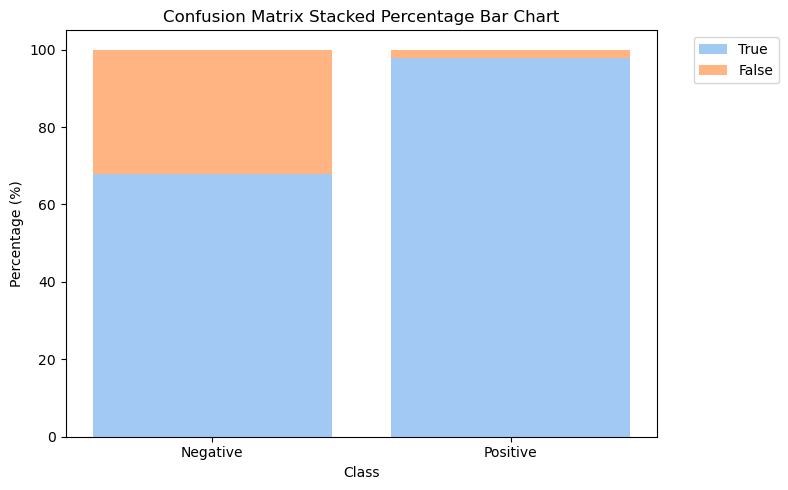

In [104]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure that you're using the Pastel color palette
sns.set_palette("pastel")

# Given confusion matrix
print("\nConfusion Matrix:")
print(confusion_df)

# Stacked bar chart for confusion matrix
true_values = [confusion_df.loc["True negative", "Predicted negative"], confusion_df.loc["True positive", "Predicted positive"]]
false_values = [confusion_df.loc["True negative", "Predicted positive"], confusion_df.loc["True positive", "Predicted negative"]]
bar_labels = ["Negative", "Positive"]

total_neg = sum(confusion_df.loc["True negative"])
total_pos = sum(confusion_df.loc["True positive"])
true_percentage = [true_values[0] / total_neg * 100, true_values[1] / total_pos * 100]
false_percentage = [false_values[0] / total_neg * 100, false_values[1] / total_pos * 100]


# Get the colors from the Pastel palette
colors = sns.color_palette("pastel", n_colors=2)

plt.figure(figsize=(8, 5))
bars1 = plt.bar(bar_labels, true_percentage, label="True", color=colors[0])
bars2 = plt.bar(bar_labels, false_percentage, bottom=true_percentage, label="False", color=colors[1])
plt.title('Confusion Matrix Stacked Percentage Bar Chart')
plt.ylabel('Percentage (%)')
plt.xlabel('Class')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # This line places the legend outside the plot
plt.tight_layout()
plt.show()


['love', 'it', 'use', 'using', 'really', 'great', 'feel', 've', 'feels', 'dry', 'definitely', 'one', 'recommend', 'well', 'will', 'good', 'used', 'texture', 'doesn', 'nice']


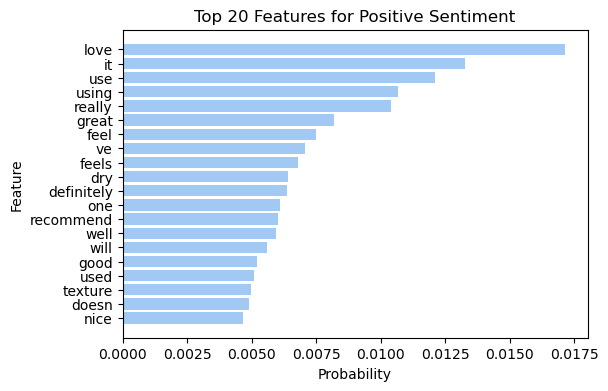

['it', 'didn', 'really', 'using', 'use', 'used', 'don', 'dry', 'one', 'love', 've', 'even', 'smell', 'much', 'doesn', 'feel', 'good', 'made', 'work', 'will']


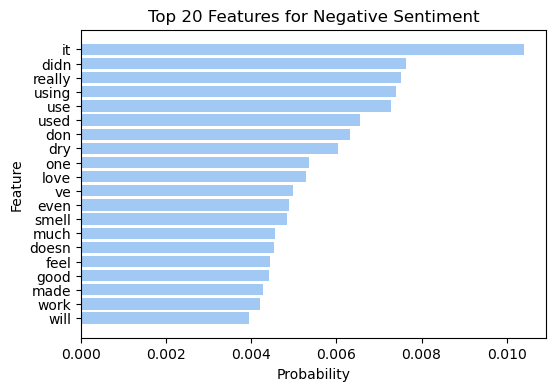

In [105]:
import matplotlib.pyplot as plt
import numpy as np

# Extract the MultinomialNB classifier from the pipeline
mnb_classifier = cus_sw_nb_classifier.classifier.named_steps['classifier']

# Convert log probabilities to regular probabilities
probs = np.exp(mnb_classifier.feature_log_prob_)

# Get the vectorizer from the pipeline to access feature names
vectorizer = cus_sw_nb_classifier.classifier.named_steps['vectorizer']
feature_names = vectorizer.get_feature_names_out()

# Map class names to indices
class_indices = {label: index for index, label in enumerate(mnb_classifier.classes_)}

def plot_top_features_for_class(class_name):
    class_index = class_indices[class_name]
    
    # Get top 20 feature indices and their probabilities
    sorted_indices = probs[class_index].argsort()[::-1][:20]
    top_probs = probs[class_index][sorted_indices]
    top_features = [feature_names[i] for i in sorted_indices]
    print(top_features)

    # Plotting
    plt.figure(figsize=(6, 4))
    plt.barh(top_features, top_probs, align='center')
    plt.xlabel('Probability')
    plt.ylabel('Feature')
    plt.title(f'Top 20 Features for {class_name.capitalize()} Sentiment')
    plt.gca().invert_yaxis()  # To display the highest probability at the top
    plt.show()

plot_top_features_for_class("positive")
plot_top_features_for_class("negative")


## Validation

In [106]:
# to set up an interactive sentiment prediction function
def interactive_sentiment_prediction(validator_instance):
    text = input("Enter the text for validation: ")
    prediction = validator_instance.predict_single(text)
    print(f"The predicted sentiment for the given text is: {prediction}")


In [107]:
# Define a function to input text and see the sentiment
def interactive_sentiment_prediction(validator):
    text = input("Enter the text for sentiment analysis: ")
    # Process and predict the sentiment
    prediction = validator.predict_single(text)
    # Output the result
    print(f"The predicted sentiment for the given text is: {prediction}")

In [108]:
# this is an interactive vaildation function, please uncomment to play around 
# # Now you can call the function to input text and get predictions
# interactive_sentiment_prediction(validator)

#### try with custom stopword model

In [109]:
# use our custom stopword model
cus_visualization = NaiveBayesVisualization(cus_sw_nb_classifier)
cus_validator = Validator(cus_sw_nb_classifier)

In [110]:
# a longer negative review text
text = 'Really cute packaging and I really wanted to love this but cannot seem to get any coverage whatsoever. I usually use a kabuki brush for application but doesn’t seem like it’s staying on my skin.' 
prediction = cus_validator.predict_single(text)
print(f"The predicted sentiment for the given text is: {prediction}")


The predicted sentiment for the given text is: negative


In [111]:
text = 'disappointed about the product!'
prediction = cus_validator.predict_single(text)
print(f"The predicted sentiment for the given text is: {prediction}")

The predicted sentiment for the given text is: negative


In [112]:
text = 'I expected product to be better' 
prediction = cus_validator.predict_single(text)
print(f"The predicted sentiment for the given text is: {prediction}")


The predicted sentiment for the given text is: positive


For negative labels, the current model is able to predict longer reviews correctly. But for shorter reviews which containing postive words inside like 'better' it is extrmely hard for the model to make correct prediction due to the nature of the model. 

In [113]:
text = 'used to hate makeup but now I love this product' 
prediction = cus_validator.predict_single(text)
print(f"The predicted sentiment for the given text is: {prediction}")

The predicted sentiment for the given text is: positive


In [114]:
text = 'A great medium to full coverage soft matte foundation but it can be a little orange ' 
prediction = cus_validator.predict_single(text)
print(f"The predicted sentiment for the given text is: {prediction}")

The predicted sentiment for the given text is: positive


the model preformed extremely well for positive reviews as expected.

#### try with undersampled model

due to the limitation of this model in detecting negative reviews, i find it interesting to explore about the undersampled model which showed a better performance in detecting negative reviews

In [115]:
# use the custom stopwords mdodel
us_visualization = NaiveBayesVisualization(undersample_nb_classifier)
us_validator = Validator(undersample_nb_classifier)

In [116]:
# the negative review which custom model failed to detect 
text = 'I expected product to be better' 
prediction = us_validator.predict_single(text)
print(f"The predicted sentiment for the given text is: {prediction}")


The predicted sentiment for the given text is: negative


In [117]:
# the postive review with negative words
text = 'used to hate makeup but now I love this product' 
prediction = us_validator.predict_single(text)
print(f"The predicted sentiment for the given text is: {prediction}")


The predicted sentiment for the given text is: negative


In [118]:
# some advacned negative review
text = 'it used to be my favorite produt in the past, but now it is not as good as before'
prediction = cus_validator.predict_single(text)
print(f"The predicted sentiment for the given text is: {prediction}")
prediction = us_validator.predict_single(text)
print(f"The predicted sentiment for the given text is: {prediction}")

The predicted sentiment for the given text is: positive
The predicted sentiment for the given text is: positive


the undersampled model did show a significant improvement in detecting negative labels, but for cases when reviews are using multiple "not" + positive words, the model still hard to detect. This is probably due to the nature of the NB model. one potential improvement is to use bigram model, but based on the previous expolrations, it seems that such treatment would cause model overfitting, especially the % of people who write review may only be a small portion, focusing too much on it is likely to drop the model preformance by a huge precent. 

## Combination of base models

In [135]:
import numpy as np

def get_probabilities(validator, data):
    return np.array([validator.predict_single_proba(text) for text in data])

def weighted_predictions(validator1, validator2, data, weight1=0.5, weight2=0.5):
    probs1 = get_probabilities(validator1, data)
    probs2 = get_probabilities(validator2, data)

    weighted_probs = (weight1 * probs1 + weight2 * probs2) / (weight1 + weight2)
    predictions = (weighted_probs > 0.5).astype(int)
    
    return predictions

def convert_to_sentiment(value):
    return "positive" if value == 1 else "negative"




In [137]:
data = ['I expected product to be better']
preds_weighted = weighted_predictions(cus_validator, us_validator, data, 0.6, 0.4)
print (f'prediction with preds_weighted is {convert_to_sentiment(preds_weighted[0])}')
# the prediction is corectly identidied as negative, perviously marked as positive by the custom model


prediction with preds_weighted is negative


In [141]:
data = ['used to hate makeup but now I love this product']
preds_weighted = weighted_predictions(cus_validator, us_validator, data, 0.6, 0.4)
print (f'prediction with preds_weighted is {convert_to_sentiment(preds_weighted[0])}')
# the prediction is corectly identidied as positive, perviously marked as negative by the undersampled

prediction with preds_weighted is positive


In [151]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_cleaned['review_text'], df_cleaned['true_sentiment'], test_size=0.4, random_state=2023)


In [159]:
from sklearn.metrics import confusion_matrix, fbeta_score, recall_score

predictions = weighted_predictions(cus_validator, us_validator, X_test, 0.6, 0.4)

y_test_int = [1 if label == "positive" else 0 for label in y_test]

f2 = fbeta_score(y_test_int, predictions, beta=2)
recall = recall_score(y_test_int, predictions)
conf_matrix = confusion_matrix(y_test_int, predictions)

print(f"Recall: {recall}")
print(f"F2 Score: {f2}")
print(f"Confusion Matrix:\n{conf_matrix}")


Recall: 0.968874728660458
F2 Score: 0.9704070218011074
Confusion Matrix:
[[ 4490  1327]
 [ 1778 55346]]


### conclusion

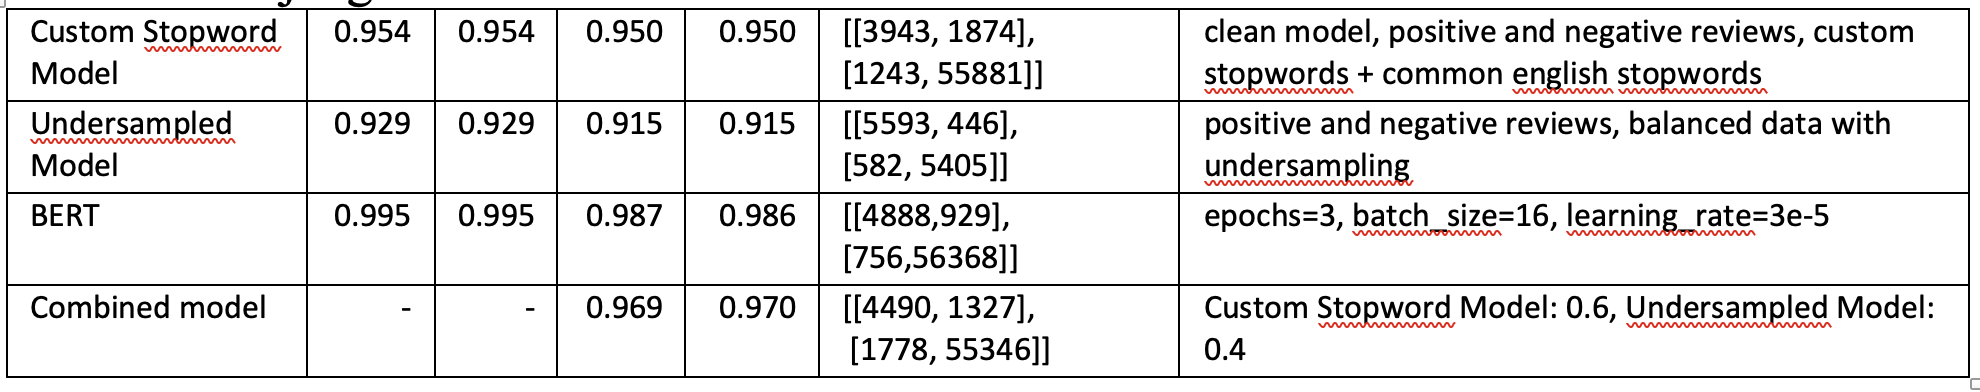

overall, model preforms improved with the weighted prediction between a undersampled (good at negative) and custom stopword model (good at positive). the prediction for negative class improved significantly by 10% without scarifying its ability in positive class detection. 

BERT, being a much advanced model, and of course, more computational intensive, is only slightly better than the combined model, 2%. Since the model is already performing generally well, the combined NB model should be good even in most situations. It is only hard to detect where there is opposite use of emotional words in the reviews, but such situation is rather rare. 
- it used to be my favorite produt in the past, but now it is not as good as before

But NB model is extremely efficient and fast to train compared to BERT model, only took about 2min v.s. 2hrs.  

Furthermore, review can be complex in the real life, there are some instance where both model may not so good at predicting. when there is a mixture is feeling expressed in the save review, even it is hard to human being to tell. 
- mixture of feeling: 'delivery is way to slow, but product is good' 

In [161]:
data = ['delivery is way to slow, but product is good']
preds_weighted = weighted_predictions(cus_validator, us_validator, data, 0.6, 0.4)
print (f'prediction with preds_weighted is {convert_to_sentiment(preds_weighted[0])}')
# the prediction is corectly identidied as positive, perviously marked as negative by the undersampled

prediction with preds_weighted is positive


In [164]:
text = 'delivery is way to slow, but product is good' 
prediction = cus_validator.predict_single(text)
print(f"The predicted sentiment for the given text is: {prediction}")

The predicted sentiment for the given text is: positive


In [165]:
text = 'delivery is way to slow, but product is good' 
prediction = us_validator.predict_single(text)
print(f"The predicted sentiment for the given text is: {prediction}")

The predicted sentiment for the given text is: negative


## Advanced Analysis

- mixture of feeling: 'delivery is way to slow, but product is good' - > how do i know each sentiment is tagged to which aespect?

In [204]:
import nltk

In [172]:
aspects = ["delivery", "product"]

def identify_aspects_and_sentiments_with_model(sentence, validator):
    # Tokenize the sentence
    tokens = nltk.word_tokenize(sentence)
    
    # Identify aspects in the sentence
    identified_aspects = [token for token in tokens if token in aspects]
    
    # For each aspect, extract context and predict sentiment using the trained model
    aspect_sentiments = {}
    for aspect in identified_aspects:
        # Find the index of the aspect in tokens
        aspect_index = tokens.index(aspect)
        
        # Consider 3 words before and after the aspect as context
        context = tokens[max(0, aspect_index - 3):aspect_index] + tokens[aspect_index + 1:min(aspect_index + 4, len(tokens))]
        
        # Predict sentiment for the context using the model
        sentiment = validator.predict_single(' '.join(context))
        
        aspect_sentiments[aspect] = sentiment
    
    return aspect_sentiments

# Test the function
sentence = "disappointed with the delivery, but i love the product"
print(identify_aspects_and_sentiments_with_model(sentence, validator))


{'delivery': 'negative', 'product': 'positive'}


lets zoom into rating = 3, and have a bit more understanding of what is going on

In [178]:
latest_review.head(3)

rating  is_recommended  helpfulness submission_time  \
0       3             0.0     0.714286      2022-12-31   
1       2             0.0     0.500000      2022-12-31   
2       5             1.0     1.000000      2022-12-31   

                                         review_text  \
0  I decided to try this as I had never used a li...   
1  Might as well be putting on Vaseline because I...   
2  Love this lip mask nothing else will do Aquaph...   

                                review_title  length  \
0  Decent, but cheaper products do the trick     172   
1                        Where’s the smell??     160   
2                                  Must buy!      92   

                                        product_name brand_name  price_usd  \
0  Lip Sleeping Mask Intense Hydration with Vitam...    LANEIGE       24.0   
1  Lip Sleeping Mask Intense Hydration with Vitam...    LANEIGE       24.0   
2  Lip Sleeping Mask Intense Hydration with Vitam...    LANEIGE       24.0   

  primary_category      secondary_category tertiary_category true_sentiment  \
0         Skincare  Lip Balms & Treatments               NaN        neutral   
1         Skincare  Lip Balms & Treatments               NaN       negative   
2         Skincare  Lip Balms & Treatments               NaN       positive   

                                   reviews_processed prediction  
0  i decided to try this as i had never used a li...    neutral  
1  might as well be putting on vaseline because i...   negative  
2  love this lip mask nothing else will do aquaph...   negative

In [179]:
df_neutral=latest_review[latest_review['true_sentiment']=='neutral']

In [180]:
X_test=df_neutral['review_text'].tolist()


In [181]:
predictions = weighted_predictions(cus_validator, us_validator, X_test, 0.6, 0.4)

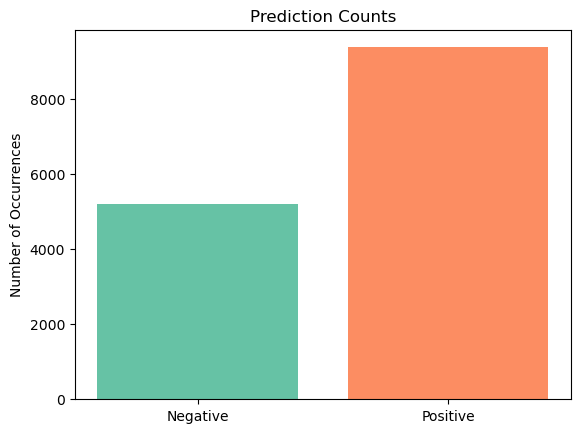

In [186]:
# Count occurrences of 0 and 1
unique, counts = np.unique(predictions, return_counts=True)
result = dict(zip(unique, counts))

colors = sns.color_palette("Set2", n_colors=2)

# Plot
labels = ['Negative', 'Positive']
values = [result[0], result[1]]

plt.bar(labels, values, color=colors)
plt.title('Prediction Counts')
plt.ylabel('Number of Occurrences')
plt.show()

In [201]:
import nltk
import pandas as pd

# just use some human interpretation to identify the aspects
aspects = ['cream','serum','moisturizer','makeup','sunscreen', 'delivery','service','deal','refill','packaging']

def identify_aspects_and_sentiments_with_model(sentence, validator):
    tokens = nltk.word_tokenize(sentence.lower())  # Consider lowercasing for better matching
    
    identified_aspects = [token for token in tokens if token in aspects]
    
    aspect_sentiments = {}
    for aspect in identified_aspects:
        aspect_indexes = [i for i, token in enumerate(tokens) if token == aspect]
        
        for aspect_index in aspect_indexes:
            context = tokens[max(0, aspect_index - 3):min(aspect_index + 4, len(tokens))]
            sentiment = validator.predict_single(' '.join(context))
            
            if aspect in aspect_sentiments:
                aspect_sentiments[aspect].append(sentiment)
            else:
                aspect_sentiments[aspect] = [sentiment]
    
    for aspect, sentiments in aspect_sentiments.items():
        aspect_sentiments[aspect] = max(set(sentiments), key=sentiments.count)
    
    return aspect_sentiments

def process_dataframe(df, column_name, validator):
    return df[column_name].apply(lambda x: identify_aspects_and_sentiments_with_model(x, validator))




In [202]:
df_neutral['aspect_sentiments'] = process_dataframe(df_neutral, 'review_text', validator)


/var/folders/8z/fr1y76rn6js5w526_mc9y1hh0000gn/T/ipykernel_59960/600101908.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_neutral['aspect_sentiments'] = process_dataframe(df_neutral, 'review_text', validator)


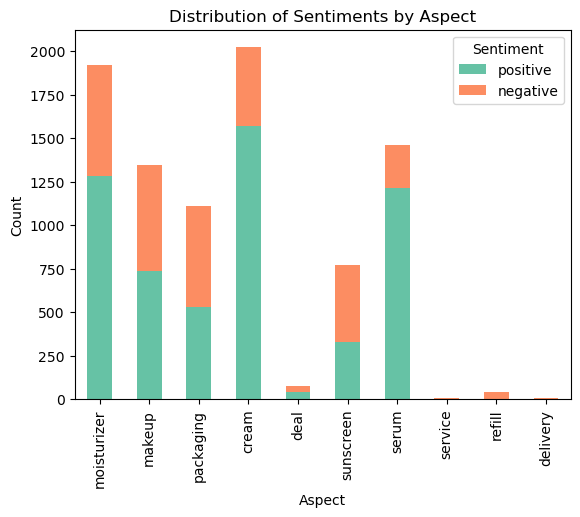

In [203]:
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict

# Initialize counters
aspect_sentiment_counts = defaultdict(lambda: defaultdict(int))

# Iterate through each dictionary in the aspect_sentiments column
for sentiments in df_neutral['aspect_sentiments']:
    for aspect, sentiment in sentiments.items():
        aspect_sentiment_counts[aspect][sentiment] += 1

# Convert to DataFrame for easy plotting
df_counts = pd.DataFrame(aspect_sentiment_counts).T.fillna(0)

# Use pastel color scheme from Set3 colormap
colors = plt.cm.Set2.colors

# Plot
ax = df_counts.plot(kind='bar', stacked=True, color=colors)
plt.xlabel('Aspect')
plt.ylabel('Count')
plt.title('Distribution of Sentiments by Aspect')
plt.legend(title='Sentiment')
plt.show()


with the use of aspects sentiment analysis, the reviews with a complex sentiments can be broken down. Despite the current version, only uses a small prototype and manually input of aespects, and the aespect is only checking on words aroud it, there is definitely a lot more to be further improved and expereiment in the futrue. 